<a href="https://colab.research.google.com/github/weswest/MSDS422/blob/main/MSDS_422_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Project Overview

This workbook performs basic introductory EDA on the Ames, Iowa Housing dataset available on Kaggle: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

This is Assignment 2 for the Northwestern MSDS-422 Practical Machine Learning course.  Abbreviated instructions for this assignment:

You are to produce a **linear regression** that predicts sale prices in the Ames, Iowa dataset.  In particular: 

1. Conduct your analysis using a cross-validation design.
2. Conduct EDA and provide appropriate visualizations in the process.
3. Build a minimum of two separate regression models using the training set.
4. Evaluate polynomial, indicator, dichotomous, & piecewise model components.
5. Create at least one feature from the data set.
6. Evaluate the models’ assumptions.
7. Evaluate goodness of fit metrics on the training and validation sets.
8. Submit predictions for the unseen test set available on Kaggle.com.
9. Provide your Kaggle user name and a screen snapshot of your Kaggle scores.
10. Discuss what your models tell you in layman’s terms



# Workbook Structure

This work pulls heavily from Assignment 1, which was a deep dive on EDA of the Ames dataset.

## Considerations for analysis vs EDA

Assignment 1 was limited to exploration of the "train" file provided in the Kaggle competition; this time we will need to also consider the "test" file.  Namely, as we create rules for handling outliers, missing values, etc we will need to
- Create our treatment using the train dataset
- Apply the treatment to the test dataset

The focus of this assignment is explicitly on **linear regression**, without taking advantage of dimension reduction features like PCA, or lasso regressions.

## Overall layout

0. Setup - loading libraries, data
1. Research into DV (train only)
2. Treatment of outliers and missing values
3. Feature research and generation
4. IV and DV feature scaling (as necessary)
5. Model development and testing


# 0 Setup


## 0.1 Setup - Load Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings('ignore')

## 0.2 Setup - Operating Environment
This code allows the Colab notebook to access my Google Drive files.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
try:
  os.chdir("drive/My Drive/MSDS/422/Ames")
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.3 Setup - Read in Data
Note: the Kaggle dataset already splits the housing data into "train" and "test" sets.  This assignment allows us to ignore the test set for now

In [3]:
df_train = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')

In [4]:
print(df_train.shape)
print(df_train.select_dtypes(include=np.number).shape)
print(df_train.select_dtypes(exclude=np.number).shape)

print('In the training dataset we have 1460 observations, 81 variables: 38 number and 43 categorical')

print(df_test.shape)
print(df_test.select_dtypes(include=np.number).shape)
print(df_test.select_dtypes(exclude=np.number).shape)

print('In the training dataset we have 1459 observations, 80 variables: 37 number and 43 categorical')

(1460, 81)
(1460, 38)
(1460, 43)
In the training dataset we have 1460 observations, 81 variables: 38 number and 43 categorical
(1459, 80)
(1459, 37)
(1459, 43)
In the training dataset we have 1459 observations, 80 variables: 37 number and 43 categorical


# 1 Explore the Dependent Variable (Sale Price)


## 1.1 DV Description

The code below shows that there is right skew: the mean of \$181k is higher than the median of \$163k.  Also, this highlights the range of sale prices from \$35k to \$755k

In [5]:
# 1.1 The code below pulls out the standard mean, median, min/max distributions for our key variable

print(df_train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


## 1.2 DV Box Plot

The box and whisker plot is useful for identifying the typical values, as well as the outliers.

The graph below shows that there are a number of sale price outliers on the upper end of the graph, which is not unexpected given the right skew.

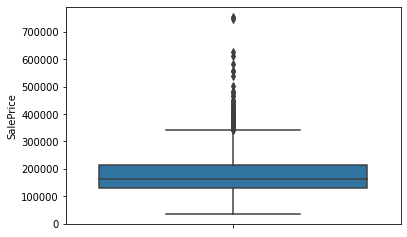

In [6]:
# 1.2 The code below reveals a large number of outliers, especially on the upper end
# This sort of result is indicative of a probable right skew

sns.boxplot( y=df_train["SalePrice"])
#plt.show()

## 1.3 DV Distribution

The next handful of code blocks get into what the DV distribution looks like.  The first code block directly shows the PD of Sale Price.  The second also overlays a normal distribution on top of the graph, to better understand how far away from normal the graph looks.

Spoiler: the Sale Price is not normal.

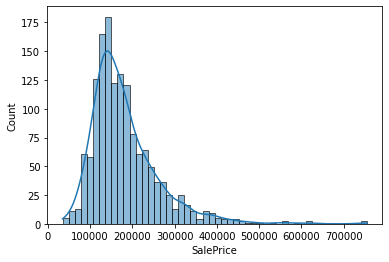

In [7]:
# 1.3 This graph below attempts to show the probability distribution of the DV
# As noted above, it looks likely there is right skew here

sns.histplot(x=df_train['SalePrice'], bins=50, kde=True)


 mu = 180921.20 and sigma = 79415.29



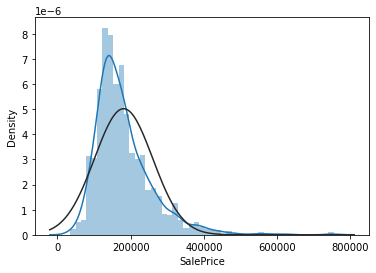

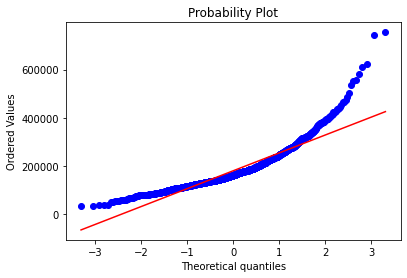

In [8]:
# Base function pulled from https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression
# and subsequently edited

# This code overlays the probability distribution of the key variable with a normal curve

def check_skewness(frame, col):
    sns.distplot(frame[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(frame[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(frame[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness(df_train, 'SalePrice')

## 1.4 DV Treatment - Log Transform
Note: this isn't specifically recommended within the assignment, but this is a useful approach to see if the transformation will result in a more normal distribution.  In this case, it very clearly does.

Note: log transformations convert the relationship between values from additive (values of 150 and 225 are 75 units apart) to multiplicative (ln(150) vs ln(225) is approximately a 50% increase).


 mu = 12.02 and sigma = 0.40



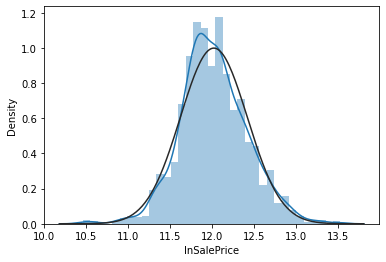

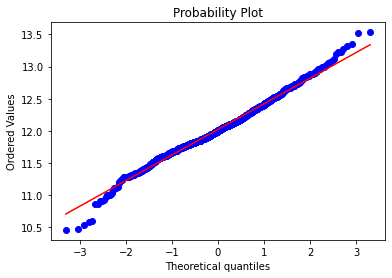

In [9]:
df_train['lnSalePrice'] = np.log(df_train['SalePrice'])
check_skewness(df_train, 'lnSalePrice')

# 2 Investigate Missing Data and Outliers

## 2.1 Investigate Missing Data



### 2.1.1 Naive Missing Data Research
Before digging into anything that we know about the data, let's take a look at missing values.

Hat tip to Dr Larry for the code used to graph missing data.

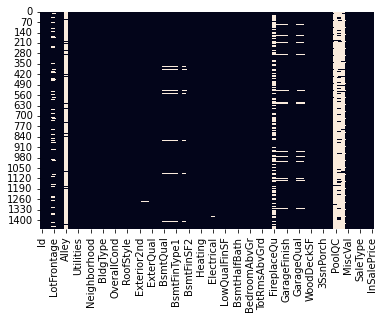

In [10]:
# Hat tip: https://github.com/dustoff06/MI/blob/main/MI%20Final%209%201%202021.ipynb

sns.heatmap(df_train.isnull(), cbar=False)

In [11]:
# Quick function that produces the 10 fields with the highest percentage of missing elements

def pct_missing(frame):
  temp = frame.isnull().sum() # This row generates a vector of Null counts
  temp = temp / len(frame) # len(df_train) is the length of the dataset.  Dividing == %
  # This prints out the top 10 fields with missing rows
  return(temp.sort_values(ascending=False).head(10))

print(pct_missing(df_train))
print(pct_missing(df_test))

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageQual      0.055479
GarageCond      0.055479
GarageFinish    0.055479
GarageType      0.055479
dtype: float64
PoolQC          0.997944
MiscFeature     0.965045
Alley           0.926662
Fence           0.801234
FireplaceQu     0.500343
LotFrontage     0.155586
GarageCond      0.053461
GarageQual      0.053461
GarageYrBlt     0.053461
GarageFinish    0.053461
dtype: float64


**Conclusion:** There are a number of data fields with many missing values

### 2.1.2 Recharacterize "NA" as "No Feature" as appropriate.

Some very light research into the data dictionary indicates that many of the fields with missing values have "NA" encoded when in reality it's "No Feature".  It's important to retain these items, e.g., we don't want to delete the 99% of records without a pool.  It also doesn't make sense to backfill these values with, e.g., the average observed size of the pool.

The code below runs through all of the fields where the data dictionary clearly indicates that "NA" indicates "none of the feature"

LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
Electrical     0.000685
lnSalePrice    0.000000
Foundation     0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
dtype: float64

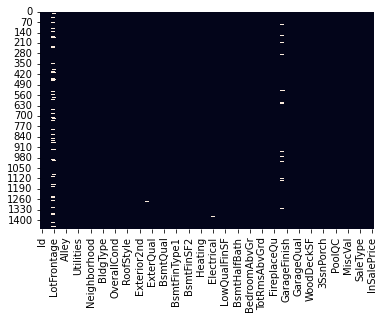

In [12]:
none_fields = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']
df_train[none_fields] = df_train[none_fields].fillna('None')

sns.heatmap(df_train.isnull(), cbar=False)
pct_missing(df_train)

LotFrontage     0.155586
GarageYrBlt     0.053461
MasVnrArea      0.010281
MSZoning        0.002742
Functional      0.001371
BsmtHalfBath    0.001371
BsmtFullBath    0.001371
Utilities       0.001371
BsmtFinSF1      0.000685
Exterior1st     0.000685
dtype: float64

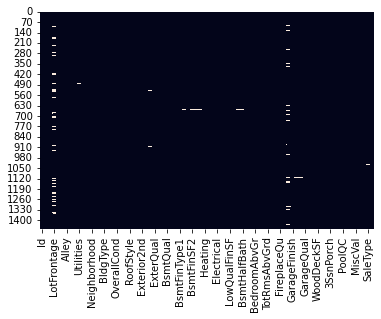

In [13]:
df_test[none_fields] = df_test[none_fields].fillna('None')

sns.heatmap(df_test.isnull(), cbar=False)
pct_missing(df_test)

**Conclusion:** Filling in these known NAs removes nearly all of the missing values from the dataset.  The remaining columns require more consideration.

### 2.1.3 Determine what to do about LotFrontage
LotFrontage is the linear feet of the property attached to a street.  There's no a priori reason from the data dictionary why this would be null.

Others who have worked with the Ames dataset (see references above) fill in the lot frontage based on the neighborhood.  That seems like a smart approach, but it may not be the best.

Below I test whether the Building Type (e.g., Single Family or Townhouse) may be a better identifier.  The answer is clearly not.

The other thing I'm considering is whether we could identify an interim model to predict lot frontage from the lot area (e.g., if we assume Lot Area is a square then frontage = sqrt(Area).  First blush it looks like that wouldn't work great, plus that raises complications.  

**Conclusion:** To get through the day I'll follow the learnings of those who came before me and backfill to equal the neighborhood median.

**Note**: We need to use the df_train dataset's median to fill in the df_test's missing values here.

In [14]:
df_train[df_train['LotFrontage'].isna()].head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,lnSalePrice
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000,12.206073
12,13,20,RL,NaN,12968,Pave,None,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737,Unf,0,175,912,GasA,...,SBrkr,912,0,0,912,1,0,1,0,2,1,TA,4,Typ,0,None,Detchd,1962.0,Unf,1,352,TA,TA,Y,140,0,0,0,176,0,None,None,None,0,9,2008,WD,Normal,144000,11.877569
14,15,20,RL,NaN,10920,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733,Unf,0,520,1253,GasA,...,SBrkr,1253,0,0,1253,1,0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1,352,TA,TA,Y,0,213,176,0,0,0,None,GdWo,None,0,5,2008,WD,Normal,157000,11.964001
16,17,20,RL,NaN,11241,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578,Unf,0,426,1004,GasA,...,SBrkr,1004,0,0,1004,1,0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2,480,TA,TA,Y,0,0,0,0,0,0,None,None,Shed,700,3,2010,WD,Normal,149000,11.911702
24,25,20,RL,NaN,8246,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188,ALQ,668,204,1060,GasA,...,SBrkr,1060,0,0,1060,1,0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1,270,TA,TA,Y,406,90,0,0,0,0,None,MnPrv,None,0,5,2010,WD,Normal,154000,11.944708
31,32,20,RL,NaN,8544,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1966,2006,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1228,1228,GasA,...,SBrkr,1228,0,0,1228,0,0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1966.0,Unf,1,271,TA,TA,Y,0,65,0,0,0,0,None,MnPrv,None,0,6,2008,WD,Normal,149350,11.914048
42,43,85,RL,NaN,9180,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,SFoyer,5,7,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,ALQ,747,LwQ,93,0,840,GasA,...,SBrkr,884,0,0,884,1,0,1,0,2,1,Gd,5,Typ,0,None,Attchd,1983.0,RFn,2,504,TA,Gd,Y,240,0,0,0,0,0,None,MnPrv,None,0,12,2007,WD,Normal,144000,11.877569
43,44,20,RL,NaN,9200,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,6,1975,1980,Hip,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,Av,LwQ,280,BLQ,491,167,938,GasA,...,SBrkr,938,0,0,938,1,0,1,0,3,1,TA,5,Typ,0,None,Detchd,1977.0,Unf,1,308,TA,TA,Y,145,0,0,0,0,0,None,MnPrv,None,0,7,2008,WD,Normal,130250,11.777211
50,51,60,RL,NaN,13869,Pave,None,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,182,Unf,0,612,794,GasA,...,SBrkr,794,676,0,1470,0,1,2,0,3,1,TA,6,Typ,0,None,Attchd,1997.0,Fin,2,388,TA,TA,Y,0,75,0,0,0,0,None,None,None,0,7,2007,WD,Normal,177000,12.083905
64,65,60,RL,NaN,9375,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5

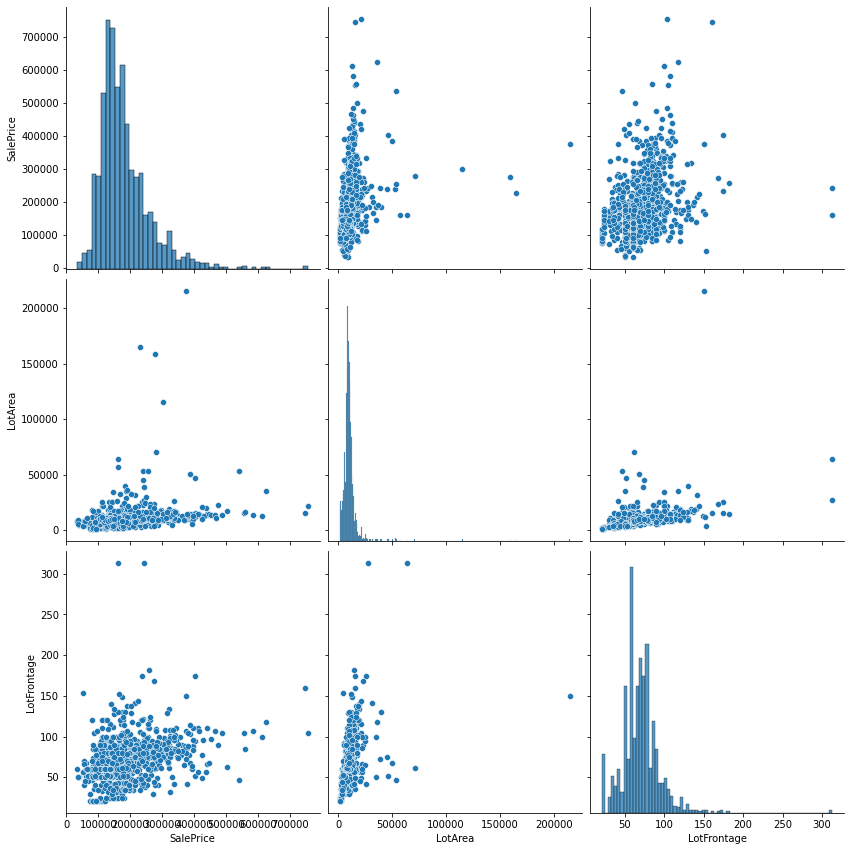

In [15]:
# The pairplot code produces all of the permutations of scatterplots for the input fields

pairs = ['SalePrice', 'LotArea', 'LotFrontage']
sns.pairplot(df_train[pairs], size = 4)
plt.show()
# Note we should probably come back to this for some of the outliers.

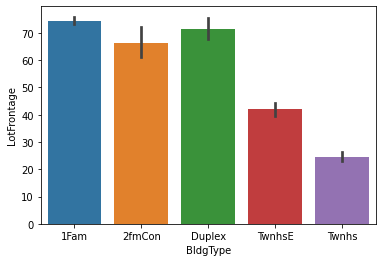

In [16]:

sns.barplot(x = df_train['BldgType'], y = df_train['LotFrontage'])


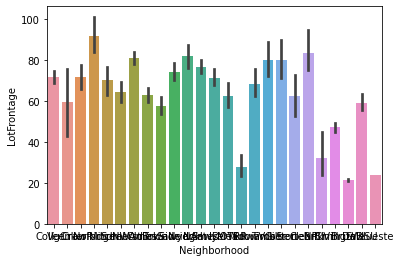

In [17]:
sns.barplot(x = df_train['Neighborhood'], y = df_train['LotFrontage'])

In [18]:
# Hat tip: https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
pct_missing(df_train)

GarageYrBlt    0.055479
MasVnrArea     0.005479
Electrical     0.000685
Foundation     0.000000
RoofStyle      0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
ExterQual      0.000000
dtype: float64

In [19]:
df_test["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
pct_missing(df_test)

GarageYrBlt     0.053461
MasVnrArea      0.010281
MSZoning        0.002742
Utilities       0.001371
Functional      0.001371
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF1      0.000685
KitchenQual     0.000685
Exterior2nd     0.000685
dtype: float64

### 2.1.4 Determine How to Handle GarageYrBlt

Ok, so these missing values are examples where there is no garage, so of course there's no year built.  What's the best way to fill these in?

I have to presume that at a later stage of feature selection the way we'd expect to use "GarageYrBlt" is to indicate whether the garage was built after the house (e.g., an addon).  If that's the case, the likely defining variable will be whether House Year = Garage Year or not.  So we will set Garage Year NAs to House Year.

In [20]:
df_train[df_train['GarageYrBlt'].isna()].head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,lnSalePrice
39,40,90,RL,65.0,6040,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,None,None,None,None,0,None,0,0,0,GasA,...,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,0,0,0,0,None,None,None,0,6,2008,WD,AdjLand,82000,11.314475
48,49,190,RM,33.0,4456,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,...,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,102,0,0,0,None,None,None,0,6,2009,New,Partial,113000,11.635143
78,79,90,RL,72.0,10778,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1768,1768,GasA,...,SBrkr,1768,0,0,1768,0,0,2,0,4,2,TA,8,Typ,0,None,None,NaN,None,0,0,None,None,Y,0,0,0,0,0,0,None,None,None,0,4,2010,WD,Normal,136500,11.824080
88,89,50,C (all),105.0,8470,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,...,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,156,0,0,0,None,MnPrv,None,0,10,2009,ConLD,Abnorml,85000,11.350407
89,90,20,RL,60.0,8070,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588,Unf,0,402,990,GasA,...,SBrkr,990,0,0,990,1,0,1,0,3,1,TA,5,Typ,0,None,None,NaN,None,0,0,None,None,Y,0,0,0,0,0,0,None,None,None,0,8,2007,WD,Normal,123600,11.724806
99,100,20,RL,77.0,9320,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1959,1959,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,569,Unf,0,381,950,GasA,...,SBrkr,1225,0,0,1225,1,0,1,1,3,1,TA,6,Typ,0,None,None,NaN,None,0,0,None,None,Y,352,0,0,0,0,0,None,None,Shed,400,1,2010,WD,Normal,128950,11.767180
108,109,50,RM,85.0,8500,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,5,7,1919,2005,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,793,793,GasW,...,FuseF,997,520,0,1517,0,0,2,0,3,1,Fa,7,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,144,0,0,0,None,None,None,0,8,2007,WD,Normal,115000,11.652687
125,126,190,RM,60.0,6780,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,1.5Fin,6,8,1935,1982,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Fa,CBlock,TA,TA,Av,GLQ,490,Unf,0,30,520,GasA,...,SBrkr,520,0,234,754,1,0,1,0,2,1,TA,5,Typ,0,None,None,NaN,None,0,0,None,None,N,53,0,0,0,0,0,None,None,None,0,6,2006,WD,Normal,84500,11.344507
127,128,45,RM,55.0,4388,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,OldTown,Feedr,Norm,1Fam,1.5Unf,5,7,1930,1950,Gable,CompShg,WdShing,Wd Sdng,None,0.0,TA,Gd,BrkTil,TA,TA,No,LwQ,116,Unf,0,556,672,GasA,...,SBrkr,840,0,0,840,0,0,1,0,3,1,TA,5,Typ,1,TA,None,NaN,None,0,0,None,None,N,0,0,0,0,0,0,None,None,None,0,6,2007,WD,Normal,87000,11.373663
140,141,20,RL,70.0,10500,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1971,1971,Gable,

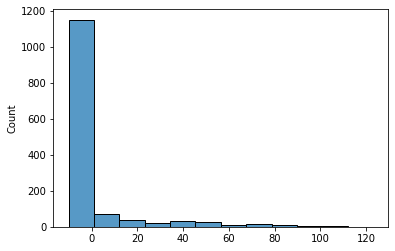

In [21]:
# This code confirms that in nearly all cases the Garage and House were built in the same year

test1 = df_train['GarageYrBlt'] - df_train['YearBuilt']
sns.histplot(test1)

In [22]:
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(df_train['YearBuilt'])
pct_missing(df_train)

MasVnrArea     0.005479
Electrical     0.000685
lnSalePrice    0.000000
Foundation     0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
ExterQual      0.000000
ExterCond      0.000000
dtype: float64

In [23]:
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(df_test['YearBuilt'])
pct_missing(df_test)

MasVnrArea      0.010281
MSZoning        0.002742
Functional      0.001371
BsmtHalfBath    0.001371
BsmtFullBath    0.001371
Utilities       0.001371
GarageCars      0.000685
KitchenQual     0.000685
Exterior2nd     0.000685
Exterior1st     0.000685
dtype: float64

### 2.1.5 Determine How To Handle MasVnrArea

These NAs are where the Masonry Veneer is "None", so these should just be zero.

In [24]:
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)
pct_missing(df_train)

Electrical     0.000685
lnSalePrice    0.000000
Foundation     0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
MasVnrArea     0.000000
ExterQual      0.000000
ExterCond      0.000000
dtype: float64

In [25]:
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)
pct_missing(df_test)

MSZoning        0.002742
Functional      0.001371
Utilities       0.001371
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
TotalBsmtSF     0.000685
SaleType        0.000685
GarageArea      0.000685
Exterior1st     0.000685
BsmtUnfSF       0.000685
dtype: float64

### 2.1.6 Determine How To Handle Electrical

The most common Electrical value is 'SBrkr' by far.  So fill with that.

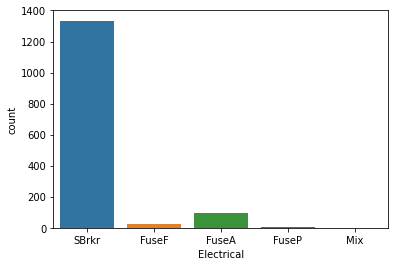

In [26]:
sns.countplot(x=df_train['Electrical'])

In [27]:
df_train['Electrical'] = df_train['Electrical'].fillna('SBrkr')
pct_missing(df_train)

lnSalePrice     0.0
YearRemodAdd    0.0
RoofMatl        0.0
Exterior1st     0.0
Exterior2nd     0.0
MasVnrType      0.0
MasVnrArea      0.0
ExterQual       0.0
ExterCond       0.0
Foundation      0.0
dtype: float64

In [28]:
df_test['Electrical'] = df_test['Electrical'].fillna('SBrkr')
pct_missing(df_test)

MSZoning        0.002742
Functional      0.001371
Utilities       0.001371
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
TotalBsmtSF     0.000685
SaleType        0.000685
GarageArea      0.000685
Exterior1st     0.000685
BsmtUnfSF       0.000685
dtype: float64

### 2.1.7 Callout: Remaining Missing Values in Test Set

After applying the Training set fillna rules, there are still a number of Test observations with missing values.  Let's quickly take a look.

We can bin the missing values in two camps:
* Categorical (MSZoning, Functional, Utilities, SaleType)
* Numerical (BsmtFullBath, BsmtHalfBath, TotalBsmtSF, GarageArea, Exterior1st, BsmtUnfSF)

For Categorical, the training dataset overwhelmingly categorizes sales into specific categories, and we will fillna with those category values.

For Numeric, these generally appear to relate to missing values, so we will fill with "0".

In [29]:
df_test[df_test.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
95,1556,50,RL,65.0,10632,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,Unf,0.0,689.0,689.0,GasA,Gd,N,SBrkr,725,499,0,1224,0.0,0.0,1,1,3,1,NaN,6,Mod,0,None,Detchd,1917.0,Unf,1.0,180.0,Fa,Fa,N,0,0,248,0,0,0,None,None,None,0,1,2010,COD,Normal
455,1916,30,NaN,80.0,21780,Grvl,None,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,None,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,None,None,None,0,3,2009,ConLD,Normal
485,1946,20,RL,80.0,31220,Pave,None,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,None,None,Shed,750,5,2008,WD,Normal
660,2121,20,RM,80.0,5940,Pave,None,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,None,None,None,None,NaN,None,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,None,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,None,MnPrv,None,0,4,2008,ConLD,Abnorml
691,2152,30,RL,104.0,19550,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,None,1940.0,None,0.0,0.0,None,None,Y,0,39,0,0,0,0,None,None,None,0,1,2008,WD,Normal
728,2189,20,RL,85.0,47007,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,None,None,None,0,7,2008,WD,Normal
756,2217,20,NaN,68.0,14584,Pave,None,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,None,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,None,None,None,0,2,2008,WD,Abnorml
790,2251,70,NaN,43.0,56600,Pave,None,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,None,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,None,None,None,0,1,2008,WD,Normal
1013,2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,771.0,771.0,GasA,Fa,Y,SBrkr,866,504,114,1484,0.0,0.0,2,0,3,1,TA,6,NaN,0,None,Detchd,1910.0,Unf,1.0,264.0,TA,Fa,N,14,211,0,0,84,0,None,None,None,0,9,2007,COD,Abnorml
1029,2490,20,RL,21.0,13770,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1

### 2.1.8 MSZoning Treatment

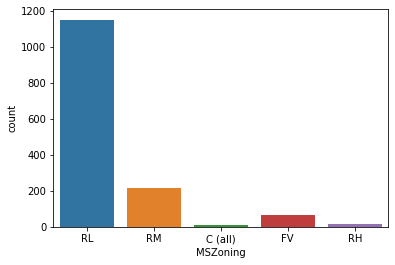

In [30]:
sns.countplot(x=df_train['MSZoning'])

In [31]:
df_test['MSZoning'] = df_test['MSZoning'].fillna('RL')
pct_missing(df_test)

Functional      0.001371
Utilities       0.001371
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
SaleType        0.000685
KitchenQual     0.000685
BsmtFinSF1      0.000685
dtype: float64

### 2.1.9 Functional Treatment

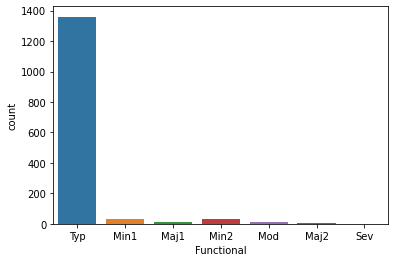

In [32]:
sns.countplot(x=df_train['Functional'])

In [33]:
df_test['Functional'] = df_test['Functional'].fillna('Typ')
pct_missing(df_test)

Utilities       0.001371
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
SaleType        0.000685
BsmtFinSF1      0.000685
KitchenQual     0.000685
Exterior1st     0.000685
dtype: float64

### 2.1.10 Utilities

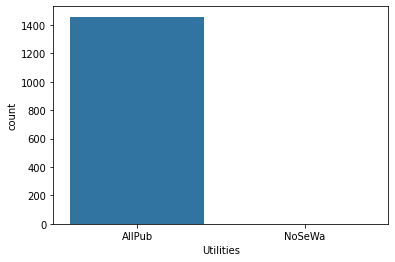

In [34]:
sns.countplot(x=df_train['Utilities'])

In [35]:
df_test['Utilities'] = df_test['Utilities'].fillna('AllPub')
pct_missing(df_test)

BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF2      0.000685
KitchenQual     0.000685
Exterior1st     0.000685
GarageCars      0.000685
GarageArea      0.000685
Exterior2nd     0.000685
BsmtFinSF1      0.000685
SaleType        0.000685
dtype: float64

### 2.1.11 SaleType Treatment

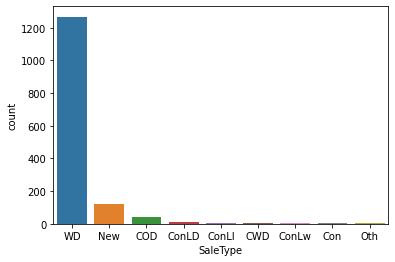

In [36]:
sns.countplot(x=df_train['SaleType'])

In [37]:
df_test['SaleType'] = df_test['SaleType'].fillna('WD')
pct_missing(df_test)

BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
BsmtFinSF1      0.000685
KitchenQual     0.000685
Exterior1st     0.000685
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

### 2.1.12 KitchenQual Treatment

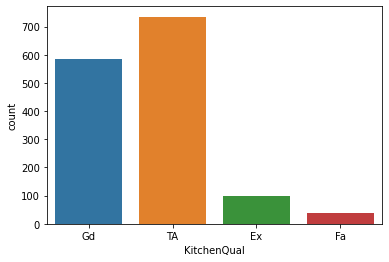

In [38]:
sns.countplot(x=df_train['KitchenQual'])

In [39]:
df_test['KitchenQual'] = df_test['KitchenQual'].fillna('TA')
pct_missing(df_test)

BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF2      0.000685
Exterior1st     0.000685
GarageCars      0.000685
GarageArea      0.000685
Exterior2nd     0.000685
BsmtUnfSF       0.000685
BsmtFinSF1      0.000685
TotalBsmtSF     0.000685
dtype: float64

### 2.1.13 Fill all remaining with 0

In [40]:
df_test = df_test.fillna(0)
pct_missing(df_test)

SaleCondition    0.0
SaleType         0.0
RoofStyle        0.0
RoofMatl         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
MasVnrArea       0.0
ExterQual        0.0
ExterCond        0.0
dtype: float64

## 2.2 Handling Outliers

If we take a naive look at sale price, then we see there are many observations that would meet the 1.5x IQR threshold.  That said, the distribution plot shared earlier in this notebook reveals a skew towards higher-priced homes that was materially resolved by log-transforming the sale price.

So for outlier treatment, we won't exclude all of the large sale prices.

Instead, we will follow an approach of identifying which fields have outliers (using the "extreme outlier" definition of 3*IQR above/below the first and third quartiles), and then graphing the field against sale price to make a judgment whether there are outliers.

### 2.2.1 Identify the fields with 3*IQR outliers

In [41]:
# Thanks for inspiration: https://stackoverflow.com/questions/39068214/how-to-count-outliers-for-all-columns-in-python/39068451#39068451

num_df_train = df_train.select_dtypes(include=np.number) # This creates a dataset that excludes all of the categorical variables
Q1 = num_df_train.quantile(0.25) # Creates a vector of the 1st quantile values
Q3 = num_df_train.quantile(0.75) # Creates a vector of the 3rd quantile values
IQR = Q3 - Q1 # Generates the IQR for each of the variables

# The code below implements an "extreme outlier" test.  Normal outliers would replace the "3 *" with "1.5 *"
temp = ((num_df_train < (Q1 - 3 * IQR)) | (num_df_train > (Q3 + 3 * IQR))).sum()
temp.sort_values(ascending=False) # Shows the fields with the most outlier observations


EnclosedPorch    208
BsmtFinSF2       167
ScreenPorch      116
BsmtHalfBath      82
KitchenAbvGr      68
MiscVal           52
LotArea           34
MasVnrArea        28
LowQualFinSF      26
3SsnPorch         24
OpenPorchSF       18
LotFrontage       13
SalePrice         12
PoolArea           7
TotalBsmtSF        5
GrLivArea          4
WoodDeckSF         3
1stFlrSF           3
GarageArea         3
OverallCond        1
BsmtFinSF1         1
BedroomAbvGr       1
TotRmsAbvGrd       1
YearRemodAdd       0
YearBuilt          0
OverallQual        0
MSSubClass         0
lnSalePrice        0
FullBath           0
BsmtUnfSF          0
2ndFlrSF           0
BsmtFullBath       0
HalfBath           0
Fireplaces         0
GarageYrBlt        0
GarageCars         0
MoSold             0
YrSold             0
Id                 0
dtype: int64

## 2.2.2 Graph Fields with Extreme Outliers vs Sale Price

The block of code below implements expert judgment for how to handle extreme outliers in the dataset

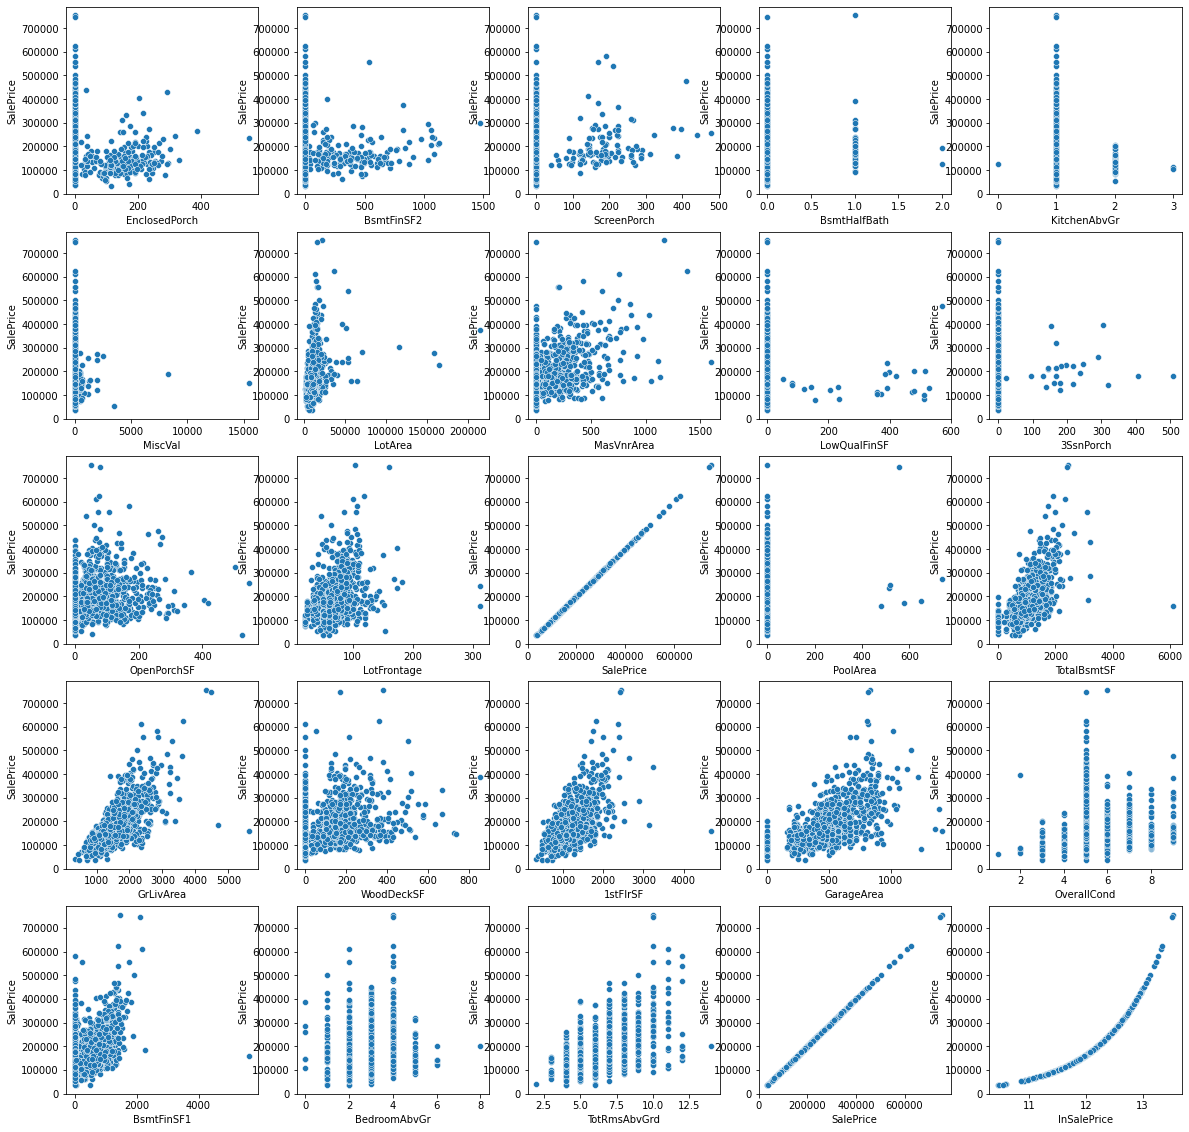

In [42]:

outliers = ['EnclosedPorch', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 'KitchenAbvGr', 'MiscVal',
            'LotArea', 'MasVnrArea', 'LowQualFinSF', '3SsnPorch', 'OpenPorchSF', 'LotFrontage', 
            'SalePrice', 'PoolArea', 'TotalBsmtSF', 'GrLivArea', 'WoodDeckSF', '1stFlrSF', 
            'GarageArea', 'OverallCond', 'BsmtFinSF1', 'BedroomAbvGr', 'TotRmsAbvGrd',
            'SalePrice', 'lnSalePrice']

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
for i in range(5):
  for j in range(5):
    n = 5*i + j
    sns.scatterplot(x=outliers[n], y='SalePrice', data=df_train, ax=axs[i, j])

#Quick note for what's going on in the code above:
# the plt.subplots command allows you to create a grid of graphs, in this case 5x5
# the i, j loops iterate, so that we populate each cell into the "ax=axs[i,j]" cell
# Note that there were 23 outliers, including sale price
# I didn't want to fight with the code for errors for the last two cells, so I just populated them w/ Sale and lnSale


### 2.2.3 Exclude Outliers as Appropriate

Reviewing the graphs above, there are only a handful of cases where the data truly look like outliers:
* LotFrontage > 200
* TotalBsmtSF > 4000
* GRLivArea > 4000 AND Sale Price <300000
* 1stFlrSF > 4000

The code below drops these fields.

Note that these thresholds result in 3 observations being dropped, so there is some overlap where individual observations triggered multiple outlier criteria.

Look to the original paper [here](http://jse.amstat.org/v19n3/decock.pdf): the author suggests removing all datapoints with above-ground livable area >4,000: these exclusions get close to the original author's intent.

In [43]:
print(df_train.shape)
df_train = df_train.drop(df_train[df_train['LotFrontage'] > 200].index)
df_train = df_train.drop(df_train[df_train['TotalBsmtSF'] > 4000].index)
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)
df_train = df_train.drop(df_train[df_train['1stFlrSF'] > 4000].index)
print(df_train.shape)


(1460, 82)
(1457, 82)


## 3 IV ~ DV Correlation Research

Also as a way of doing some basic starts, we will look at which variables appear to be most highly correlated with sale price.

The homework assignment asks us to look at three fields.  I'll select two numeric and two categorical.

## 3.1 Numeric Fields

We'll use a correlation matrix to identify a few interesting fields for further research.

The code below pulls out the numeric fields with >0.5 correlation with SalePrice.  Note that "Sale Price" and "ln Sale Price" (created above) are triggreed.

The highest-correlated variables are:
* "OverallQual" (80% correlated)
* "GrLivArea" (73% correlated)


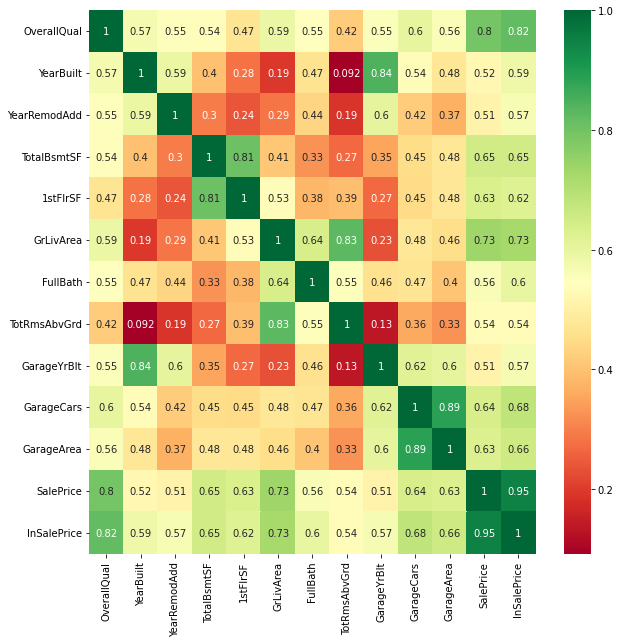

In [44]:
# Thanks to https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression

corrmat = df_train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5] # the 0.5 is the cutoff for how related the variable should be
plt.figure(figsize=(10,10))
g = sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# 3.1.1 OverallQual

OverallQual is actually a categorical variable.  It is represented as a number, 1-10, with 1 = "Very Poor" and 10 = "Very Excellent."

The graphs below show that there is definitely an upward trend in sales price for higher quality.  Looking at the ln Sales, there isn't a lot of room for binning these, other than at the low end.

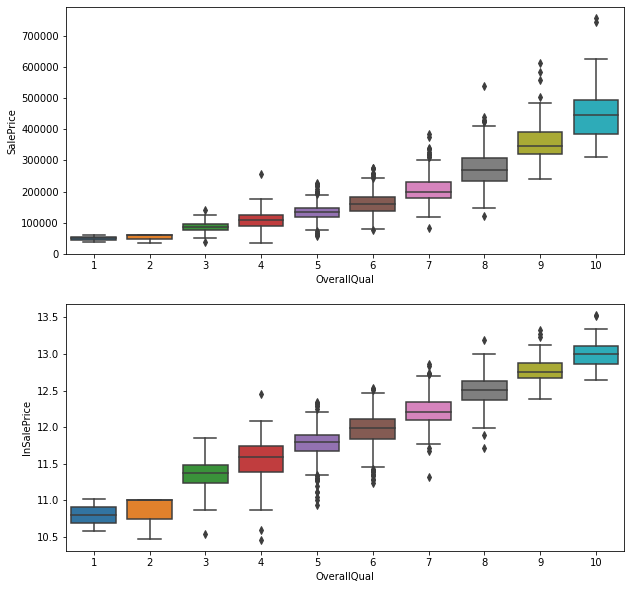

In [45]:
def boxresearch(col):
  fig, axs = plt.subplots(nrows=2, figsize=(10,10))

  sns.boxplot(x=df_train[col], y = df_train['SalePrice'], ax = axs[0])
  sns.boxplot(x=df_train[col], y = df_train['lnSalePrice'], ax = axs[1])

boxresearch('OverallQual')


### 3.1.2 GrLivArea vs OverallQual

GrLivArea is the total livable square footage aboveground.  In theory, bigger = better.

To bring in some of that quality research, I color-code the scatterplot based on the quality score.  Note that some of the quality values get relatively thin, so I perform some basic binning here, with 1-3 as red, 4-6 as yellow, etc.

The striking conclusion here is that the yellows, greens, and some purples, all overlap in the livable area range of ~1300 to ~2500: in this range it seems like sale price is more strongly dictated by quality rather than by size.

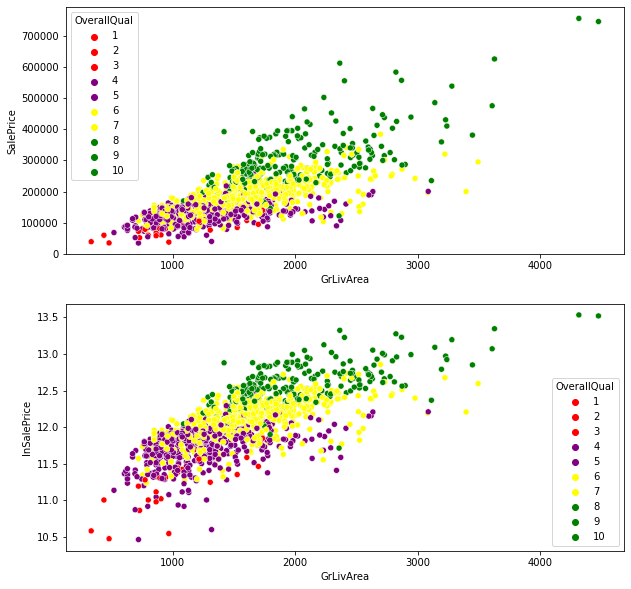

In [46]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))

colors = ['red', 'red', 'red', 'purple', 'purple', 'yellow', 'yellow', 'green', 'green', 'green']
#colors = ['red', 'blue', 'cyan', 'yellow', 'purple', 'magenta', 'black', 'green', 'orange', 'purple']


sns.scatterplot(x=df_train['GrLivArea'], y = df_train['SalePrice'], hue = df_train['OverallQual'], palette = colors, ax = axs[0])
sns.scatterplot(x=df_train['GrLivArea'], y = df_train['lnSalePrice'], hue = df_train['OverallQual'], palette = colors, ax = axs[1])


### 3.1.2 GrLivArea vs OverallCond

GrLivArea is the total livable square footage aboveground.  In theory, bigger = better.

To bring in some of that quality research, I color-code the scatterplot based on the quality score.  Note that some of the quality values get relatively thin, so I perform some basic binning here, with 1-3 as red, 4-6 as yellow, etc.

The striking conclusion here is that the yellows, greens, and some purples, all overlap in the livable area range of ~1300 to ~2500: in this range it seems like sale price is more strongly dictated by quality rather than by size.

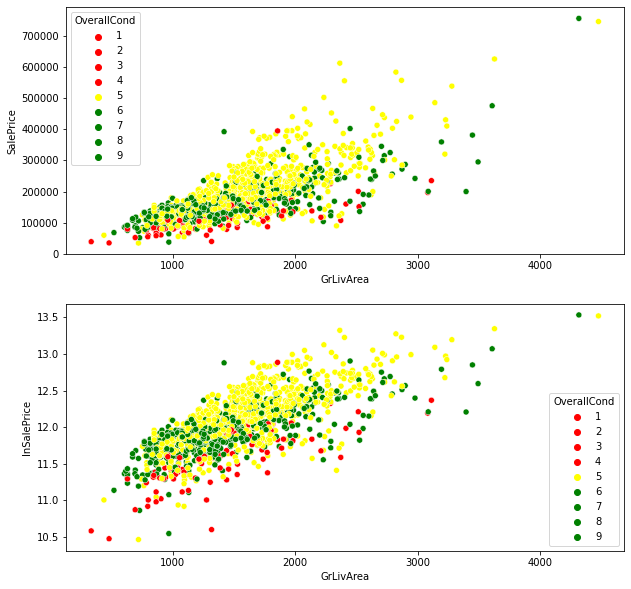

In [47]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))

colors = ['red', 'red', 'red', 'red', 'yellow', 'green', 'green', 'green', 'green']
#colors = ['red', 'blue', 'cyan', 'yellow', 'purple', 'magenta', 'black', 'green', 'orange', 'purple']


sns.scatterplot(x=df_train['GrLivArea'], y = df_train['SalePrice'], hue = df_train['OverallCond'], palette = colors, ax = axs[0])
sns.scatterplot(x=df_train['GrLivArea'], y = df_train['lnSalePrice'], hue = df_train['OverallCond'], palette = colors, ax = axs[1])


## 3.2 Categorical Fields

For this stage we will grab a few categorical variables and try to identify whether there's a relationship.

Two immediately come to mind:
* Neighborhood.  Different areas probably have notably different sales expectations
* Month and/or Year Sold.  Two things going on here: first, there is well-known seasonality in home sales in the summer vs winter so we would expect to see some implication in sales price.  Second, the financial crisis happened in 2009 so we'd expect to see some drop in sales pre vs post.

### 3.2.1 Neighborhood Category

Yup.  Clearly a difference in sales price here.

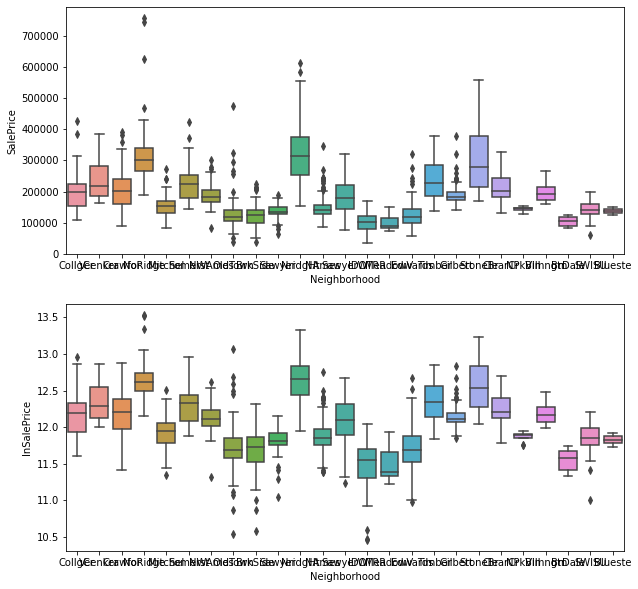

In [48]:
boxresearch('Neighborhood')

### 3.2.2 Date Sold

I was really surprised that there's relatively little impact on sale price in 2006-2007 vs 2008, 2009, 2010.  Maybe Ames, Iowa is too small to have been materially affected by the downturn.

I created a Year-Month variable (Feature Selection!), and there's some strong discontinuity there.  It may be worth using Year-Month as a predictor rather than Year or Month on its own.

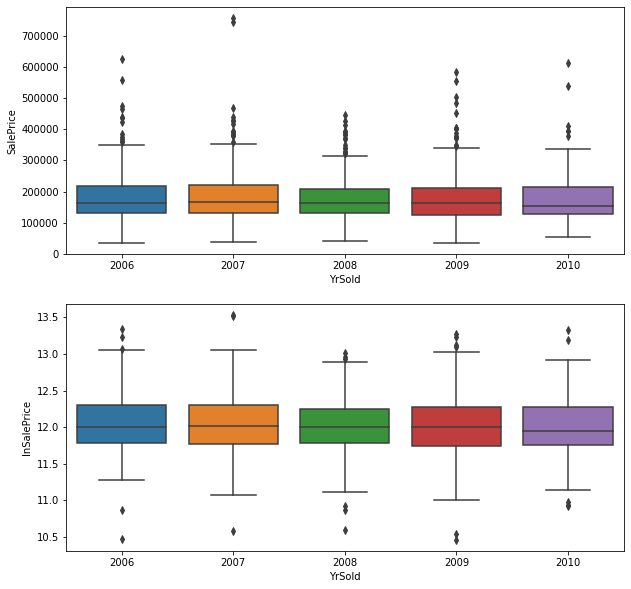

In [49]:
boxresearch('YrSold')

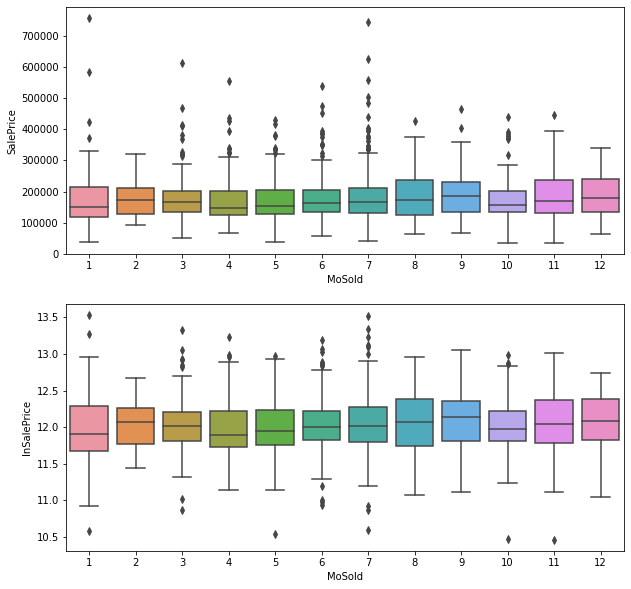

In [50]:
boxresearch('MoSold')

In [51]:
#df_train['YrMoSold'] = df_train['YrSold'].astype('str') + '-' + df_train['MoSold'].astype('str')

#boxresearch('YrMoSold')


# 4 Feature Generation

At the top of the house, we're going to combine test and train

In [52]:
df_train_backup = df_train.copy()
df_test_backup = df_test.copy()
#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

ntrain = df_train.shape[0]
y_train = df_train.SalePrice.values
y_train_final = np.log(y_train)
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)
df_all.drop(['SalePrice', 'lnSalePrice'], axis=1, inplace=True)

def printsize(frame):
  print('Size of dataset: {} rows, {} columns'.format(frame.shape[0], frame.shape[1]))

printsize(df_train)
printsize(df_test)
printsize(df_all)

Size of dataset: 1457 rows, 81 columns
Size of dataset: 1459 rows, 79 columns
Size of dataset: 2916 rows, 79 columns


## 4.1 Reclassification for Categorical Variables



### 4.1.X MSSubClass

This field has the following assignments, duplicative with other data, so dropped

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

In [53]:
df_all.drop(['MSSubClass'], axis=1, inplace=True)
printsize(df_all)

Size of dataset: 2916 rows, 78 columns


### 4.1.X MSZoning

       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

  RL (Residential Low Density) is the referent

In [54]:
print(pd.value_counts(df_all.MSZoning, normalize='columns'))

mszoning0_dict = {'RL': 0, 'RM': 1, 'FV': 0, 'RH': 0, 'C (all)': 0} #RM
mszoning1_dict = {'RL': 0, 'RM': 0, 'FV': 1, 'RH': 0, 'C (all)': 0} #FV
mszoning2_dict = {'RL': 0, 'RM': 0, 'FV': 0, 'RH': 1, 'C (all)': 1} #Other


df_all['Zoning_RM'] = df_all['MSZoning'].replace(dict(mszoning0_dict))
df_all['Zoning_FV'] = df_all['MSZoning'].replace(dict(mszoning1_dict))
df_all['Zoning_Other'] = df_all['MSZoning'].replace(dict(mszoning1_dict))

print(pd.value_counts(df_all.Zoning_RM, normalize='columns'))
print(pd.value_counts(df_all.Zoning_FV, normalize='columns'))
print(pd.value_counts(df_all.Zoning_Other, normalize='columns'))
df_all=df_all.drop(columns=['MSZoning'])

printsize(df_all)

RL         0.777092
RM         0.157750
FV         0.047668
RH         0.008916
C (all)    0.008573
Name: MSZoning, dtype: float64
0    0.84225
1    0.15775
Name: Zoning_RM, dtype: float64
0    0.952332
1    0.047668
Name: Zoning_FV, dtype: float64
0    0.952332
1    0.047668
Name: Zoning_Other, dtype: float64
Size of dataset: 2916 rows, 80 columns


### 4.1.X Street

       Grvl	Gravel	
       Pave	Paved

  Nearly all are Paved.  Drop column

In [55]:
print(pd.value_counts(df_all.Street, normalize='columns'))

df_all.drop(['Street'], axis=1, inplace=True)
printsize(df_all)

Pave    0.995885
Grvl    0.004115
Name: Street, dtype: float64
Size of dataset: 2916 rows, 79 columns


### 4.1.X Alley

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

Not obviously valuable.  Drop

None    0.932099
Grvl    0.041152
Pave    0.026749
Name: Alley, dtype: float64


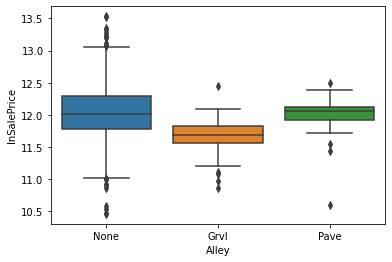

In [56]:
print(pd.value_counts(df_all.Alley, normalize='columns'))
sns.boxplot( x = df_train['Alley'], y=df_train["lnSalePrice"])

In [57]:
df_all.drop(['Alley'], axis=1, inplace=True)
printsize(df_all)

Size of dataset: 2916 rows, 78 columns


### 4.1.X LotShape

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

Irregular lots tend to be higher sale price (bigger?)
Will save the variable, treating "Regular" as the referant

Reg    0.637517
IR1    0.331619
IR2    0.025720
IR3    0.005144
Name: LotShape, dtype: float64


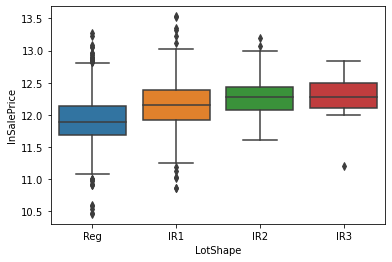

In [58]:
print(pd.value_counts(df_all.LotShape, normalize='columns'))
sns.boxplot( x = df_train['LotShape'], y=df_train["lnSalePrice"])

In [59]:
print(pd.value_counts(df_all.LotShape, normalize='columns'))

lotshape_dict = {'Reg': 0, 'IR1': 1, 'IR2': 1, 'IR3': 1}

df_all['LotShape_Irr'] = df_all['LotShape'].replace(dict(lotshape_dict))

print(pd.value_counts(df_all.LotShape_Irr, normalize='columns'))
df_all=df_all.drop(columns=['LotShape'])

printsize(df_all)

Reg    0.637517
IR1    0.331619
IR2    0.025720
IR3    0.005144
Name: LotShape, dtype: float64
0    0.637517
1    0.362483
Name: LotShape_Irr, dtype: float64
Size of dataset: 2916 rows, 78 columns


### 4.1.X LandContour

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression

Dropped

Lvl    0.899177
HLS    0.040809
Bnk    0.039438
Low    0.020576
Name: LandContour, dtype: float64


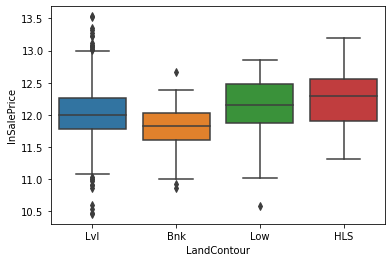

In [60]:
print(pd.value_counts(df_all.LandContour, normalize='columns'))
sns.boxplot( x = df_train['LandContour'], y=df_train["lnSalePrice"])

In [61]:
df_all.drop(['LandContour'], axis=1, inplace=True)
printsize(df_all)

Size of dataset: 2916 rows, 77 columns


### 4.1.X Utilities

Almost all are "AllPub".  Drop

AllPub    0.999657
NoSeWa    0.000343
Name: Utilities, dtype: float64


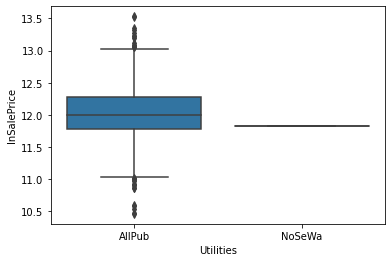

In [62]:
print(pd.value_counts(df_all.Utilities, normalize='columns'))
sns.boxplot( x = df_train['Utilities'], y=df_train["lnSalePrice"])

In [63]:
df_all.drop(['Utilities'], axis=1, inplace=True)
printsize(df_all)

Size of dataset: 2916 rows, 76 columns


### 4.1.X LotConfig

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

Looks like Cul de Sac is more valuable.
Inside is referant

Inside     0.730796
Corner     0.174897
CulDSac    0.060357
FR2        0.029150
FR3        0.004801
Name: LotConfig, dtype: float64


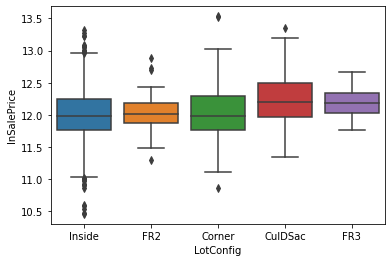

In [64]:
print(pd.value_counts(df_all.LotConfig, normalize='columns'))
sns.boxplot( x = df_train['LotConfig'], y=df_train["lnSalePrice"])

In [65]:
print(pd.value_counts(df_all.LotConfig, normalize='columns'))

lotconfig0_dict = {'Inside': 0, 'CulDSac': 1, 'FR2': 0, 'Corner': 0, 'FR3': 0} #Cul de Sac
lotconfig1_dict = {'Inside': 0, 'CulDSac': 0, 'FR2': 1, 'Corner': 1, 'FR3': 1} #Other

df_all['LotConfig_Culdsac'] = df_all['LotConfig'].replace(dict(lotconfig0_dict))
df_all['LotConfig_Other'] = df_all['LotConfig'].replace(dict(lotconfig1_dict))

print(pd.value_counts(df_all.LotConfig_Culdsac, normalize='columns'))
print(pd.value_counts(df_all.LotConfig_Other, normalize='columns'))
df_all=df_all.drop(columns=['LotConfig'])

printsize(df_all)

Inside     0.730796
Corner     0.174897
CulDSac    0.060357
FR2        0.029150
FR3        0.004801
Name: LotConfig, dtype: float64
0    0.939643
1    0.060357
Name: LotConfig_Culdsac, dtype: float64
0    0.791152
1    0.208848
Name: LotConfig_Other, dtype: float64
Size of dataset: 2916 rows, 77 columns


### 4.1.X LandSlope

       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

No differentiation.  Drop

Gtl    0.951989
Mod    0.042524
Sev    0.005487
Name: LandSlope, dtype: float64


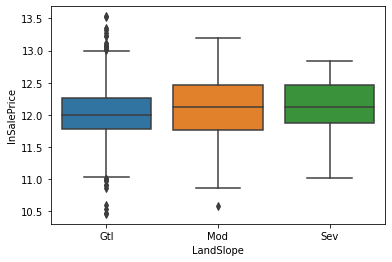

In [66]:
print(pd.value_counts(df_all.LandSlope, normalize='columns'))
sns.boxplot( x = df_train['LandSlope'], y=df_train["lnSalePrice"])

In [67]:
df_all.drop(['LandSlope'], axis=1, inplace=True)
printsize(df_all)

Size of dataset: 2916 rows, 76 columns


### 4.1.X Neighborhood

A bunch of research above on quality and neighborhood.  Rather than binning the neighborhoods together, I'm going to rely on the quality rating and drop this variable

In [68]:
df_all.drop(['Neighborhood'], axis=1, inplace=True)
printsize(df_all)


Size of dataset: 2916 rows, 75 columns


### 4.1.X Condition1

For the most part, there aren't features.  The features generally look to be negative unless explicitly highlighted as positive.  Condition1 is populated first, then condition2.

We will classify our variables with 'Normal' as our referant, with positive and negative conditions.

We are going to drop Cond2 since it's sparsely populated.


Norm      0.861111
Feedr     0.055898
Artery    0.031550
RRAn      0.017147
PosN      0.013032
RRAe      0.009602
PosA      0.006516
RRNn      0.003086
RRNe      0.002058
Name: Condition1, dtype: float64


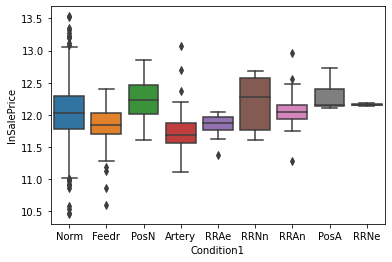

In [69]:
print(pd.value_counts(df_all.Condition1, normalize='columns'))
sns.boxplot( x = df_train['Condition1'], y=df_train["lnSalePrice"])

In [70]:
print(pd.value_counts(df_all.Condition1, normalize='columns'))

cond0_dict = {'Norm': 0, 'Artery': 1, 'RRNn': 1, 'Feedr': 1, 'PosA': 0, 'PosN': 0, 'RRNe': 1, 'RRAn': 1, 'RRAe': 1} #Negative
cond1_dict = {'Norm': 0, 'Artery': 0, 'RRNn': 0, 'Feedr': 0, 'PosA': 1, 'PosN': 1, 'RRNe': 0, 'RRAn': 0, 'RRAe': 0} #Positive

df_all['Condition_Neg'] = df_all['Condition1'].replace(dict(cond0_dict))
df_all['Condition_Pos'] = df_all['Condition1'].replace(dict(cond1_dict))

print(pd.value_counts(df_all.Condition_Neg, normalize='columns'))
print(pd.value_counts(df_all.Condition_Pos, normalize='columns'))
df_all=df_all.drop(columns=['Condition1'])
printsize(df_all)

Norm      0.861111
Feedr     0.055898
Artery    0.031550
RRAn      0.017147
PosN      0.013032
RRAe      0.009602
PosA      0.006516
RRNn      0.003086
RRNe      0.002058
Name: Condition1, dtype: float64
0    0.880658
1    0.119342
Name: Condition_Neg, dtype: float64
0    0.980453
1    0.019547
Name: Condition_Pos, dtype: float64
Size of dataset: 2916 rows, 76 columns


### 4.1.X Condition2
Dropping.  See above

In [71]:
df_all=df_all.drop(columns=['Condition2'])
printsize(df_all)

Size of dataset: 2916 rows, 75 columns


### 4.1.X BldgType

1Fam is referant

1Fam      0.830590
TwnhsE    0.077846
Duplex    0.037380
Twnhs     0.032922
2fmCon    0.021262
Name: BldgType, dtype: float64


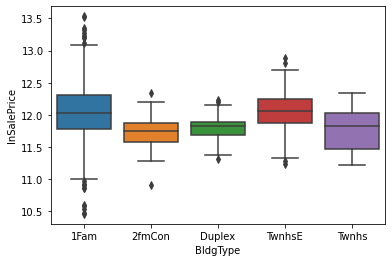

In [72]:
print(pd.value_counts(df_all.BldgType, normalize='columns'))
sns.boxplot( x = df_train['BldgType'], y=df_train["lnSalePrice"])

In [73]:
print(pd.value_counts(df_all.BldgType, normalize='columns'))

bt_dict = {'1Fam': 0, '2fmCon': 1, 'Duplex': 1, 'TwnhsE': 1, 'Twnhs': 1} #Other

df_all['BldgType_Other'] = df_all['BldgType'].replace(dict(bt_dict))

print(pd.value_counts(df_all.BldgType_Other, normalize='columns'))
df_all=df_all.drop(columns=['BldgType'])
printsize(df_all)

1Fam      0.830590
TwnhsE    0.077846
Duplex    0.037380
Twnhs     0.032922
2fmCon    0.021262
Name: BldgType, dtype: float64
0    0.83059
1    0.16941
Name: BldgType_Other, dtype: float64
Size of dataset: 2916 rows, 75 columns


### 4.1.X HouseStyle

There's enough diffferentiation to legit one-hot encode these, but the "n" for many of the categories is too small.  So we will have 1 story be referant, then we'll have 2-story, 1.5 finished, and all other



1Story    0.504115
2Story    0.298354
1.5Fin    0.107682
SLvl      0.043896
SFoyer    0.028464
2.5Unf    0.008230
1.5Unf    0.006516
2.5Fin    0.002743
Name: HouseStyle, dtype: float64


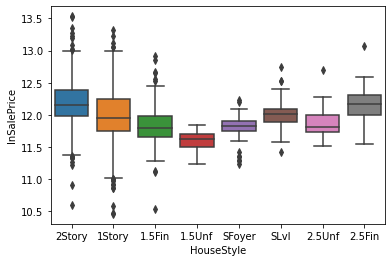

In [74]:
print(pd.value_counts(df_all.HouseStyle, normalize='columns'))
sns.boxplot( x = df_train['HouseStyle'], y=df_train["lnSalePrice"])

In [75]:
print(pd.value_counts(df_all.HouseStyle, normalize='columns'))

housestyle0_dict = {'1Story': 0, '2Story': 1, '1.5Fin': 0, 'SLvl': 0, 'SFoyer': 0, '2.5Unf': 0, '1.5Unf': 0, '2.5Fin': 0} #2Story
housestyle1_dict = {'1Story': 0, '2Story': 0, '1.5Fin': 1, 'SLvl': 0, 'SFoyer': 0, '2.5Unf': 0, '1.5Unf': 0, '2.5Fin': 0} #1.5Finished
housestyle2_dict = {'1Story': 0, '2Story': 0, '1.5Fin': 0, 'SLvl': 1, 'SFoyer': 1, '2.5Unf': 1, '1.5Unf': 1, '2.5Fin': 1} #All Other

df_all['HouseStyle_2Story'] = df_all['HouseStyle'].replace(dict(housestyle0_dict))
df_all['HouseStyle_15Fin'] = df_all['HouseStyle'].replace(dict(housestyle1_dict))
df_all['HouseStyle_Other'] = df_all['HouseStyle'].replace(dict(housestyle2_dict))

print(pd.value_counts(df_all.HouseStyle_2Story, normalize='columns'))
print(pd.value_counts(df_all.HouseStyle_15Fin, normalize='columns'))
print(pd.value_counts(df_all.HouseStyle_Other, normalize='columns'))
df_all=df_all.drop(columns=['HouseStyle'])
printsize(df_all)

1Story    0.504115
2Story    0.298354
1.5Fin    0.107682
SLvl      0.043896
SFoyer    0.028464
2.5Unf    0.008230
1.5Unf    0.006516
2.5Fin    0.002743
Name: HouseStyle, dtype: float64
0    0.701646
1    0.298354
Name: HouseStyle_2Story, dtype: float64
0    0.892318
1    0.107682
Name: HouseStyle_15Fin, dtype: float64
0    0.910151
1    0.089849
Name: HouseStyle_Other, dtype: float64
Size of dataset: 2916 rows, 77 columns


### 4.1.X OverallQual

The research above identifies a handful of bins for quality.  The scores are 1 = Very Poor to 10 = Very Excellent.

Research above informs the categorization of 1-3, 4-5, 6-7, 8-10

1-3 will be the referant

In [76]:

print(pd.value_counts(df_all.OverallQual, normalize='columns'))

qual0_dict = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0} # Medium
qual1_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0} # High
qual2_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1} # VHigh

df_all['OverallQual_Med'] = df_all['OverallQual'].replace(dict(qual0_dict))
df_all['OverallQual_High'] = df_all['OverallQual'].replace(dict(qual1_dict))
df_all['OverallQual_VHigh'] = df_all['OverallQual'].replace(dict(qual2_dict))

print(pd.value_counts(df_all.OverallQual_Med, normalize='columns'))
print(pd.value_counts(df_all.OverallQual_High, normalize='columns'))
print(pd.value_counts(df_all.OverallQual_VHigh, normalize='columns'))
df_all=df_all.drop(columns=['OverallQual'])
printsize(df_all)

5     0.282922
6     0.250686
7     0.205418
8     0.117284
4     0.077503
9     0.036694
3     0.013717
10    0.009945
2     0.004458
1     0.001372
Name: OverallQual, dtype: float64
0    0.639575
1    0.360425
Name: OverallQual_Med, dtype: float64
0    0.543896
1    0.456104
Name: OverallQual_High, dtype: float64
0    0.836077
1    0.163923
Name: OverallQual_VHigh, dtype: float64
Size of dataset: 2916 rows, 79 columns


### 4.1.X OverallCond

The research above identifies a handful of bins for quality.  The scores are 1 = Very Poor to 10 = Very Excellent.

Research above informs the categorization of 1-4, 5, and 6-10

1-4 will be the referant

In [77]:

print(pd.value_counts(df_all.OverallCond, normalize='columns'))

cond0_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0} # Medium
cond1_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1} # High

df_all['OverallCond_Med'] = df_all['OverallCond'].replace(dict(cond0_dict))
df_all['OverallCond_High'] = df_all['OverallCond'].replace(dict(cond1_dict))

print(pd.value_counts(df_all.OverallCond_Med, normalize='columns'))
print(pd.value_counts(df_all.OverallCond_High, normalize='columns'))
df_all=df_all.drop(columns=['OverallCond'])
printsize(df_all)

5    0.563443
6    0.182099
7    0.133402
8    0.049383
4    0.034636
3    0.017147
9    0.014060
2    0.003429
1    0.002401
Name: OverallCond, dtype: float64
1    0.563443
0    0.436557
Name: OverallCond_Med, dtype: float64
0    0.621056
1    0.378944
Name: OverallCond_High, dtype: float64
Size of dataset: 2916 rows, 80 columns


### 4.1.X RoofStyle

Dropped

Gable      0.792181
Hip        0.188272
Gambrel    0.007545
Flat       0.006516
Mansard    0.003772
Shed       0.001715
Name: RoofStyle, dtype: float64


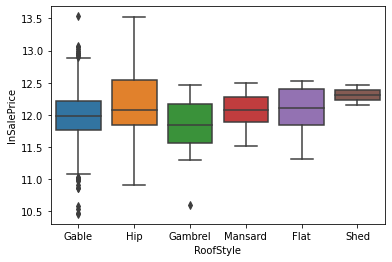

In [78]:
print(pd.value_counts(df_all.RoofStyle, normalize='columns'))
sns.boxplot( x = df_train['RoofStyle'], y=df_train["lnSalePrice"])

In [79]:
df_all=df_all.drop(columns=['RoofStyle'])
printsize(df_all)

Size of dataset: 2916 rows, 79 columns


### 4.1.X RoofMatl

Dropped.  Nearly all are CompShg

CompShg    0.985940
Tar&Grv    0.007545
WdShake    0.003086
WdShngl    0.002401
Membran    0.000343
Metal      0.000343
Roll       0.000343
Name: RoofMatl, dtype: float64


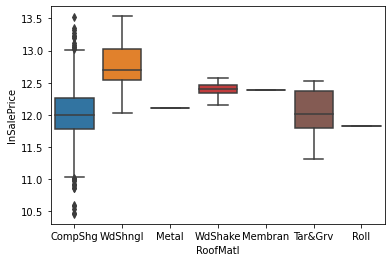

In [80]:
print(pd.value_counts(df_all.RoofMatl, normalize='columns'))
sns.boxplot( x = df_train['RoofMatl'], y=df_train["lnSalePrice"])

In [81]:
df_all=df_all.drop(columns=['RoofMatl'])
printsize(df_all)

Size of dataset: 2916 rows, 78 columns


### 4.1.X Exterior1st

Dropped

VinylSd    0.351509
MetalSd    0.154321
HdBoard    0.151578
Wd Sdng    0.140604
Plywood    0.075789
CemntBd    0.042867
BrkFace    0.029835
WdShing    0.019204
AsbShng    0.015089
Stucco     0.014403
BrkComm    0.002058
CBlock     0.000686
AsphShn    0.000686
Stone      0.000686
ImStucc    0.000343
0          0.000343
Name: Exterior1st, dtype: float64


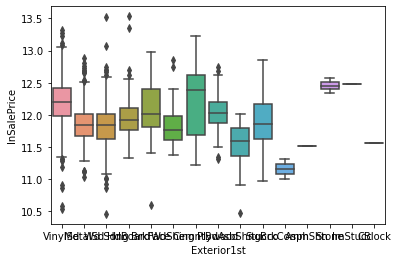

In [82]:
print(pd.value_counts(df_all.Exterior1st, normalize='columns'))
sns.boxplot( x = df_train['Exterior1st'], y=df_train["lnSalePrice"])

In [83]:
df_all=df_all.drop(columns=['Exterior1st'])
printsize(df_all)

Size of dataset: 2916 rows, 77 columns


### 4.1.X Exterior2nd

Dropped

VinylSd    0.347737
MetalSd    0.153292
HdBoard    0.139232
Wd Sdng    0.133745
Plywood    0.092593
CmentBd    0.042867
Wd Shng    0.027778
BrkFace    0.016118
Stucco     0.015775
AsbShng    0.013032
Brk Cmn    0.007545
ImStucc    0.005144
Stone      0.002058
AsphShn    0.001372
CBlock     0.001029
Other      0.000343
0          0.000343
Name: Exterior2nd, dtype: float64


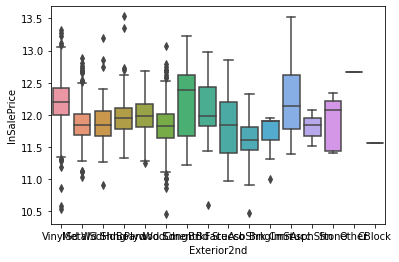

In [84]:
print(pd.value_counts(df_all.Exterior2nd, normalize='columns'))
sns.boxplot( x = df_train['Exterior2nd'], y=df_train["lnSalePrice"])

In [85]:
df_all=df_all.drop(columns=['Exterior2nd'])
printsize(df_all)

Size of dataset: 2916 rows, 76 columns


### 4.1.X MasVnrType

Brick, Stone, or None.  None is referant

None       0.605281
BrkFace    0.301440
Stone      0.084705
BrkCmn     0.008573
Name: MasVnrType, dtype: float64


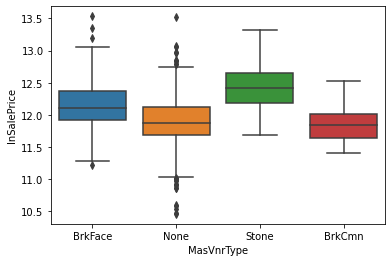

In [86]:
print(pd.value_counts(df_all.MasVnrType, normalize='columns'))
sns.boxplot( x = df_train['MasVnrType'], y=df_train["lnSalePrice"])

In [87]:
print(pd.value_counts(df_all.MasVnrType, normalize='columns'))

masvnrtype0_dict = {'None': 0, 'BrkFace': 1, 'Stone': 0, 'BrkCmn': 1} # Brick
masvnrtype1_dict = {'None': 0, 'BrkFace': 0, 'Stone': 1, 'BrkCmn': 0} # Stone

df_all['MasVnrType_Brick'] = df_all['MasVnrType'].replace(dict(masvnrtype0_dict))
df_all['MasVnrType_Stone'] = df_all['MasVnrType'].replace(dict(masvnrtype1_dict))

print(pd.value_counts(df_all.MasVnrType_Brick, normalize='columns'))
print(pd.value_counts(df_all.MasVnrType_Stone, normalize='columns'))
df_all=df_all.drop(columns=['MasVnrType'])
printsize(df_all)

None       0.605281
BrkFace    0.301440
Stone      0.084705
BrkCmn     0.008573
Name: MasVnrType, dtype: float64
0    0.689986
1    0.310014
Name: MasVnrType_Brick, dtype: float64
0    0.915295
1    0.084705
Name: MasVnrType_Stone, dtype: float64
Size of dataset: 2916 rows, 77 columns


### 4.1.X ExterQual

Combine Average with Fair as the Referant.  Have Good and Excellent as "above average"

TA    0.616255
Gd    0.335734
Ex    0.036008
Fa    0.012003
Name: ExterQual, dtype: float64


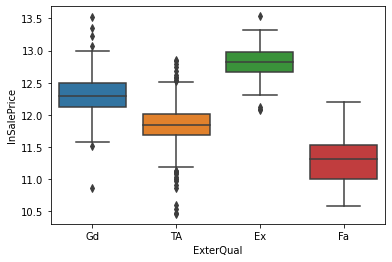

In [88]:
print(pd.value_counts(df_all.ExterQual, normalize='columns'))
sns.boxplot( x = df_train['ExterQual'], y=df_train["lnSalePrice"])

In [89]:
print(pd.value_counts(df_all.ExterQual, normalize='columns'))

exterqual_dict = {'TA': 0, 'Gd': 1, 'Ex': 1, 'Fa': 0} # Above average

df_all['ExterQual_Good'] = df_all['ExterQual'].replace(dict(exterqual_dict))

print(pd.value_counts(df_all.ExterQual_Good, normalize='columns'))
df_all=df_all.drop(columns=['ExterQual'])
printsize(df_all)

TA    0.616255
Gd    0.335734
Ex    0.036008
Fa    0.012003
Name: ExterQual, dtype: float64
0    0.628258
1    0.371742
Name: ExterQual_Good, dtype: float64
Size of dataset: 2916 rows, 77 columns


### 4.1.X ExterCond

Combine Average with Fair as the Referant.  Have Good and Excellent as "above average"

TA    0.869342
Gd    0.102538
Fa    0.022977
Ex    0.004115
Po    0.001029
Name: ExterCond, dtype: float64


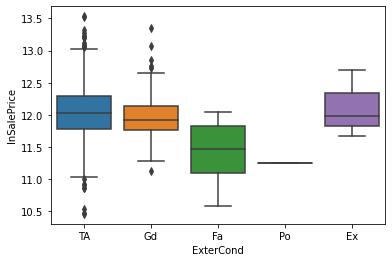

In [90]:
print(pd.value_counts(df_all.ExterCond, normalize='columns'))
sns.boxplot( x = df_train['ExterCond'], y=df_train["lnSalePrice"])

In [91]:
print(pd.value_counts(df_all.ExterCond, normalize='columns'))

extercond_dict = {'TA': 0, 'Gd': 1, 'Ex': 1, 'Fa': 0, 'Po': 0} # Above average

df_all['ExterCond_Good'] = df_all['ExterCond'].replace(dict(extercond_dict))

print(pd.value_counts(df_all.ExterCond_Good, normalize='columns'))
df_all=df_all.drop(columns=['ExterCond'])
printsize(df_all)

TA    0.869342
Gd    0.102538
Fa    0.022977
Ex    0.004115
Po    0.001029
Name: ExterCond, dtype: float64
0    0.893347
1    0.106653
Name: ExterCond_Good, dtype: float64
Size of dataset: 2916 rows, 77 columns


### 4.1.X Foundation

       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

Poured Concrete will be the referant

PConc     0.447874
CBlock    0.423182
BrkTil    0.106653
Slab      0.016804
Stone     0.003772
Wood      0.001715
Name: Foundation, dtype: float64


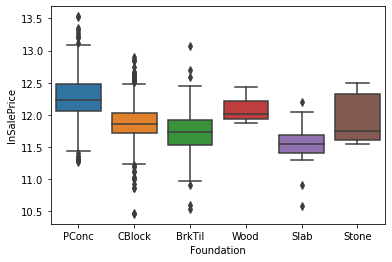

In [92]:
print(pd.value_counts(df_all.Foundation, normalize='columns'))
sns.boxplot( x = df_train['Foundation'], y=df_train["lnSalePrice"])

In [93]:
print(pd.value_counts(df_all.Foundation, normalize='columns'))

foundation0_dict = {'PConc': 0, 'CBlock': 1, 'BrkTil': 0, 'Wood': 0, 'Slab': 0, 'Stone': 0} # Cinder Block
foundation1_dict = {'PConc': 0, 'CBlock': 0, 'BrkTil': 1, 'Wood': 1, 'Slab': 1, 'Stone': 1} # Other

df_all['Foundation_Cinder'] = df_all['Foundation'].replace(dict(foundation0_dict))
df_all['Foundation_Other'] = df_all['Foundation'].replace(dict(foundation1_dict))

print(pd.value_counts(df_all.Foundation_Cinder, normalize='columns'))
print(pd.value_counts(df_all.Foundation_Other, normalize='columns'))
df_all=df_all.drop(columns=['Foundation'])
printsize(df_all)

PConc     0.447874
CBlock    0.423182
BrkTil    0.106653
Slab      0.016804
Stone     0.003772
Wood      0.001715
Name: Foundation, dtype: float64
0    0.576818
1    0.423182
Name: Foundation_Cinder, dtype: float64
0    0.871056
1    0.128944
Name: Foundation_Other, dtype: float64
Size of dataset: 2916 rows, 78 columns


### 4.1.X BsmtQual

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

Indicators for Good and Great; others will be referant

TA      0.439986
Gd      0.414266
Ex      0.087791
Fa      0.030178
None    0.027778
Name: BsmtQual, dtype: float64


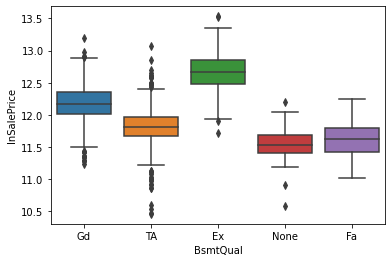

In [94]:
print(pd.value_counts(df_all.BsmtQual, normalize='columns'))
sns.boxplot( x = df_train['BsmtQual'], y=df_train["lnSalePrice"])

In [95]:
print(pd.value_counts(df_all.BsmtQual, normalize='columns'))

bsmtqual0_dict = {'None': 0, 'Ex': 0, 'Gd': 1, 'TA': 0, 'Fa': 0, 'Po': 0} # Good
bsmtqual1_dict = {'None': 0, 'Ex': 1, 'Gd': 0, 'TA': 0, 'Fa': 0, 'Po': 0} # Great

df_all['BsmtQual_Good'] = df_all['BsmtQual'].replace(dict(bsmtqual0_dict))
df_all['BsmtQual_Great'] = df_all['BsmtQual'].replace(dict(bsmtqual1_dict))

print(pd.value_counts(df_all.BsmtQual_Good, normalize='columns'))
print(pd.value_counts(df_all.BsmtQual_Great, normalize='columns'))
df_all=df_all.drop(columns=['BsmtQual'])
printsize(df_all)

TA      0.439986
Gd      0.414266
Ex      0.087791
Fa      0.030178
None    0.027778
Name: BsmtQual, dtype: float64
0    0.585734
1    0.414266
Name: BsmtQual_Good, dtype: float64
0    0.912209
1    0.087791
Name: BsmtQual_Great, dtype: float64
Size of dataset: 2916 rows, 79 columns


### 4.1.X BsmtCond

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

Not enough distribution.  Delete

TA      0.892661
Gd      0.041838
Fa      0.035665
None    0.028121
Po      0.001715
Name: BsmtCond, dtype: float64


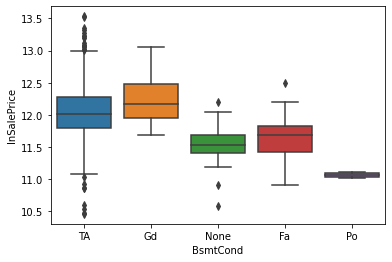

In [96]:
print(pd.value_counts(df_all.BsmtCond, normalize='columns'))
sns.boxplot( x = df_train['BsmtCond'], y=df_train["lnSalePrice"])

In [97]:

df_all=df_all.drop(columns=['BsmtCond'])
printsize(df_all)

Size of dataset: 2916 rows, 78 columns


### 4.1.X BsmExposure

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

Most is "none".  Delete

No      0.652949
Av      0.143347
Gd      0.093621
Mn      0.081962
None    0.028121
Name: BsmtExposure, dtype: float64


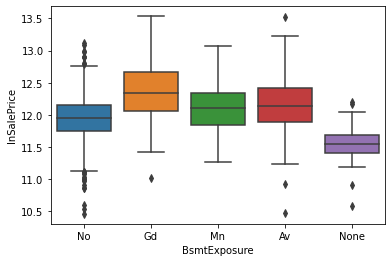

In [98]:
print(pd.value_counts(df_all.BsmtExposure, normalize='columns'))
sns.boxplot( x = df_train['BsmtExposure'], y=df_train["lnSalePrice"])

In [99]:

df_all=df_all.drop(columns=['BsmtExposure'])
printsize(df_all)

Size of dataset: 2916 rows, 77 columns


### 4.1.X BsmtFinType1

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

Indicators for Good; others will be referant

Unf     0.291838
GLQ     0.290123
ALQ     0.147119
Rec     0.098765
BLQ     0.092250
LwQ     0.052812
None    0.027092
Name: BsmtFinType1, dtype: float64


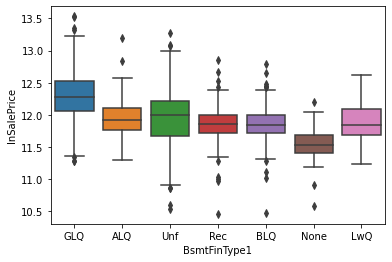

In [100]:
print(pd.value_counts(df_all.BsmtFinType1, normalize='columns'))
sns.boxplot( x = df_train['BsmtFinType1'], y=df_train["lnSalePrice"])

In [101]:
print(pd.value_counts(df_all.BsmtFinType1, normalize='columns'))

bsmtfintype_dict = {'GLQ': 1, 'ALQ': 0, 'Unf': 0, 'Rec': 0, 'BLQ': 0, 'None': 0, 'LwQ': 0} # Good

df_all['BsmtFinType_Good'] = df_all['BsmtFinType1'].replace(dict(bsmtfintype_dict))

print(pd.value_counts(df_all.BsmtFinType_Good, normalize='columns'))
df_all=df_all.drop(columns=['BsmtFinType1'])
printsize(df_all)

Unf     0.291838
GLQ     0.290123
ALQ     0.147119
Rec     0.098765
BLQ     0.092250
LwQ     0.052812
None    0.027092
Name: BsmtFinType1, dtype: float64
0    0.709877
1    0.290123
Name: BsmtFinType_Good, dtype: float64
Size of dataset: 2916 rows, 77 columns


### BsmtFinType2

Delete.  Not useful

In [102]:
df_all=df_all.drop(columns=['BsmtFinType2'])
printsize(df_all)

Size of dataset: 2916 rows, 76 columns


### 4.1.X Heating

Nearly all is Gas.  Drop

GasA     0.984568
GasW     0.009259
Grav     0.003086
Wall     0.002058
OthW     0.000686
Floor    0.000343
Name: Heating, dtype: float64


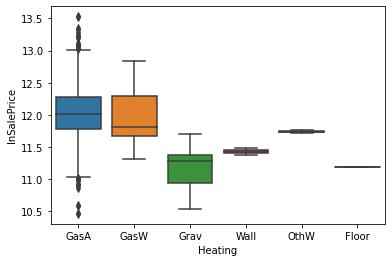

In [103]:
print(pd.value_counts(df_all.Heating, normalize='columns'))
sns.boxplot( x = df_train['Heating'], y=df_train["lnSalePrice"])

In [104]:

df_all=df_all.drop(columns=['Heating'])
printsize(df_all)

Size of dataset: 2916 rows, 75 columns


### 4.1.X HeatingQC

Drop

Ex    0.510974
TA    0.293896
Gd    0.162551
Fa    0.031550
Po    0.001029
Name: HeatingQC, dtype: float64


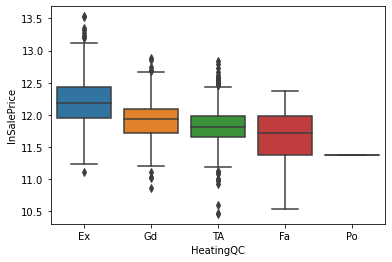

In [105]:
print(pd.value_counts(df_all.HeatingQC, normalize='columns'))
sns.boxplot( x = df_train['HeatingQC'], y=df_train["lnSalePrice"])

In [106]:

df_all=df_all.drop(columns=['HeatingQC'])
printsize(df_all)

Size of dataset: 2916 rows, 74 columns


### 4.1.X CentralAir


Yes will be referant

Y    0.932785
N    0.067215
Name: CentralAir, dtype: float64


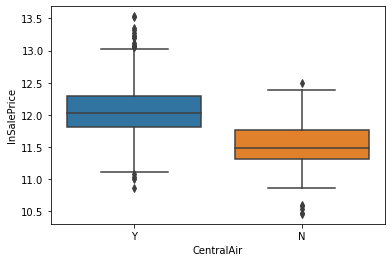

In [107]:
print(pd.value_counts(df_all.CentralAir, normalize='columns'))
sns.boxplot( x = df_train['CentralAir'], y=df_train["lnSalePrice"])

In [108]:
print(pd.value_counts(df_all.CentralAir, normalize='columns'))

centralair_dict = {'Y': 0, 'N': 1} # No air

df_all['CentralAir_No'] = df_all['CentralAir'].replace(dict(centralair_dict))

print(pd.value_counts(df_all.CentralAir_No, normalize='columns'))
df_all=df_all.drop(columns=['CentralAir'])
printsize(df_all)

Y    0.932785
N    0.067215
Name: CentralAir, dtype: float64
0    0.932785
1    0.067215
Name: CentralAir_No, dtype: float64
Size of dataset: 2916 rows, 74 columns


### 4.1.X Electrical


Standard Breaker is the referant

SBrkr    0.915295
FuseA    0.064472
FuseF    0.017147
FuseP    0.002743
Mix      0.000343
Name: Electrical, dtype: float64


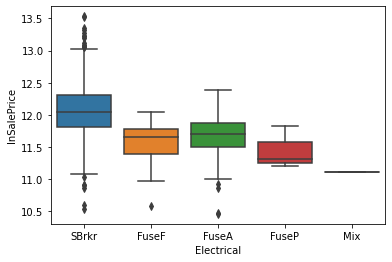

In [109]:
print(pd.value_counts(df_all.Electrical, normalize='columns'))
sns.boxplot( x = df_train['Electrical'], y=df_train["lnSalePrice"])

In [110]:
print(pd.value_counts(df_all.Electrical, normalize='columns'))

electrical_dict = {'SBrkr': 0, 'FuseA': 1, 'FuseF': 1, 'FuseP': 1, 'Mix': 1} # Fuse box

df_all['Electrical_Fuse'] = df_all['Electrical'].replace(dict(electrical_dict))

print(pd.value_counts(df_all.Electrical_Fuse, normalize='columns'))
df_all=df_all.drop(columns=['Electrical'])
printsize(df_all)

SBrkr    0.915295
FuseA    0.064472
FuseF    0.017147
FuseP    0.002743
Mix      0.000343
Name: Electrical, dtype: float64
0    0.915295
1    0.084705
Name: Electrical_Fuse, dtype: float64
Size of dataset: 2916 rows, 74 columns


### 4.1.X KitchenQual


Typical + Fair is referant

TA    0.512003
Gd    0.394376
Ex    0.069616
Fa    0.024005
Name: KitchenQual, dtype: float64


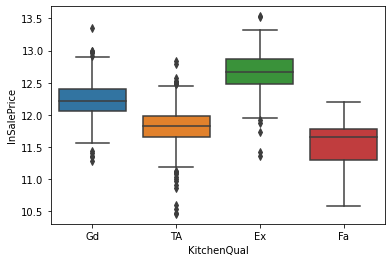

In [111]:
print(pd.value_counts(df_all.KitchenQual, normalize='columns'))
sns.boxplot( x = df_train['KitchenQual'], y=df_train["lnSalePrice"])

In [112]:
print(pd.value_counts(df_all.KitchenQual, normalize='columns'))

kitchenqual_dict = {'Ex': 1, 'Gd': 1, 'TA': 0, 'Fa': 0, 'Po': 0}

df_all['KitchenQual_Good'] = df_all['KitchenQual'].replace(dict(kitchenqual_dict))

print(pd.value_counts(df_all.KitchenQual_Good, normalize='columns'))
df_all=df_all.drop(columns=['KitchenQual'])
printsize(df_all)

TA    0.512003
Gd    0.394376
Ex    0.069616
Fa    0.024005
Name: KitchenQual, dtype: float64
0    0.536008
1    0.463992
Name: KitchenQual_Good, dtype: float64
Size of dataset: 2916 rows, 74 columns


### 4.1.X Functional

Dropped

Typ     0.931413
Min2    0.024005
Min1    0.022291
Mod     0.012003
Maj1    0.006516
Maj2    0.003086
Sev     0.000686
Name: Functional, dtype: float64


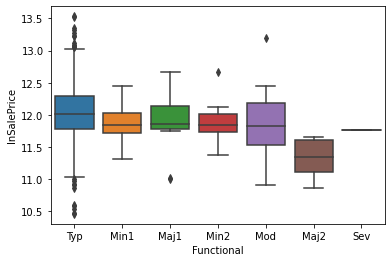

In [113]:
print(pd.value_counts(df_all.Functional, normalize='columns'))
sns.boxplot( x = df_train['Functional'], y=df_train["lnSalePrice"])

In [114]:
df_all=df_all.drop(columns=['Functional'])
printsize(df_all)

Size of dataset: 2916 rows, 73 columns


### 4.1.X FireplaceQu


Dropped

None    0.486968
Gd      0.254115
TA      0.203018
Fa      0.025377
Po      0.015775
Ex      0.014746
Name: FireplaceQu, dtype: float64


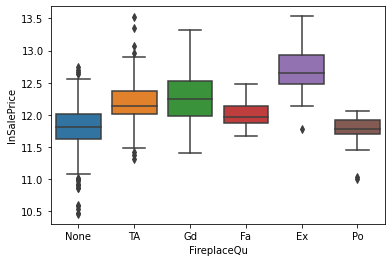

In [115]:
print(pd.value_counts(df_all.FireplaceQu, normalize='columns'))
sns.boxplot( x = df_train['FireplaceQu'], y=df_train["lnSalePrice"])

In [116]:
df_all=df_all.drop(columns=['FireplaceQu'])
printsize(df_all)

Size of dataset: 2916 rows, 72 columns


### 4.1.X GarageType

Attached + BuiltIn = 1
All other is referant

Attchd     0.590192
Detchd     0.267147
BuiltIn    0.063443
None       0.053841
Basment    0.012346
2Types     0.007888
CarPort    0.005144
Name: GarageType, dtype: float64


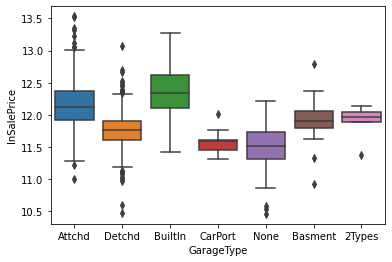

In [117]:
print(pd.value_counts(df_all.GarageType, normalize='columns'))
sns.boxplot( x = df_train['GarageType'], y=df_train["lnSalePrice"])

In [118]:
print(pd.value_counts(df_all.GarageType, normalize='columns'))

garagetype_dict = {'2Types': 0, 'Attchd': 1, 'Basment': 0, 'BuiltIn': 1, 'CarPort': 0, 'Detchd': 0, 'None': 0}

df_all['GarageType_Attached'] = df_all['GarageType'].replace(dict(garagetype_dict))

print(pd.value_counts(df_all.GarageType_Attached, normalize='columns'))
df_all=df_all.drop(columns=['GarageType'])
printsize(df_all)

Attchd     0.590192
Detchd     0.267147
BuiltIn    0.063443
None       0.053841
Basment    0.012346
2Types     0.007888
CarPort    0.005144
Name: GarageType, dtype: float64
1    0.653635
0    0.346365
Name: GarageType_Attached, dtype: float64
Size of dataset: 2916 rows, 72 columns


### 4.1.X GarageFinish

Dropped

Unf     0.421811
RFn     0.277778
Fin     0.245885
None    0.054527
Name: GarageFinish, dtype: float64


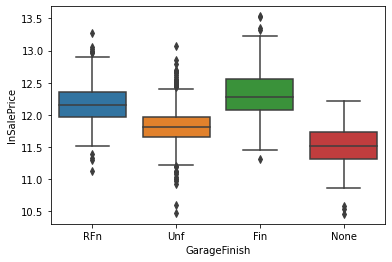

In [119]:
print(pd.value_counts(df_all.GarageFinish, normalize='columns'))
sns.boxplot( x = df_train['GarageFinish'], y=df_train["lnSalePrice"])

In [120]:

df_all=df_all.drop(columns=['GarageFinish'])
printsize(df_all)

Size of dataset: 2916 rows, 71 columns


### 4.1.X GarageQual

Dropped

TA      0.891975
None    0.054527
Fa      0.042524
Gd      0.008230
Po      0.001715
Ex      0.001029
Name: GarageQual, dtype: float64


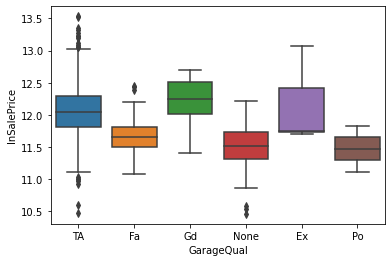

In [121]:
print(pd.value_counts(df_all.GarageQual, normalize='columns'))
sns.boxplot( x = df_train['GarageQual'], y=df_train["lnSalePrice"])

In [122]:

df_all=df_all.drop(columns=['GarageQual'])
printsize(df_all)

Size of dataset: 2916 rows, 70 columns


### 4.1.X GarageCond

Dropped

TA      0.909122
None    0.054527
Fa      0.025377
Gd      0.005144
Po      0.004801
Ex      0.001029
Name: GarageCond, dtype: float64


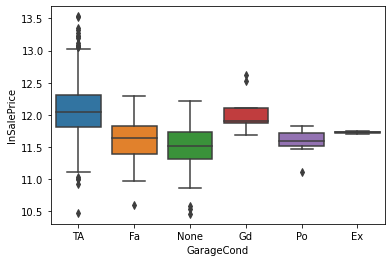

In [123]:
print(pd.value_counts(df_all.GarageCond, normalize='columns'))
sns.boxplot( x = df_train['GarageCond'], y=df_train["lnSalePrice"])

In [124]:

df_all=df_all.drop(columns=['GarageCond'])
printsize(df_all)

Size of dataset: 2916 rows, 69 columns


### 4.1.X PavedDrive

Dropped

Y    0.904664
N    0.074074
P    0.021262
Name: PavedDrive, dtype: float64


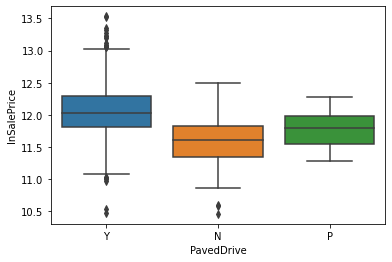

In [125]:
print(pd.value_counts(df_all.PavedDrive, normalize='columns'))
sns.boxplot( x = df_train['PavedDrive'], y=df_train["lnSalePrice"])

In [126]:

df_all=df_all.drop(columns=['PavedDrive'])
printsize(df_all)

Size of dataset: 2916 rows, 68 columns


### 4.1.X PoolQC

None is Referant

None    0.996914
Ex      0.001372
Gd      0.001029
Fa      0.000686
Name: PoolQC, dtype: float64


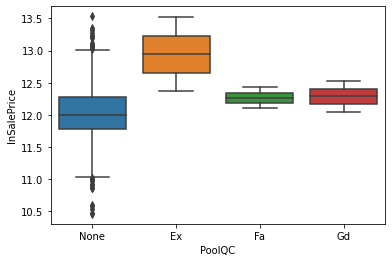

In [127]:
print(pd.value_counts(df_all.PoolQC, normalize='columns'))
sns.boxplot( x = df_train['PoolQC'], y=df_train["lnSalePrice"])

In [128]:
print(pd.value_counts(df_all.PoolQC, normalize='columns'))

poolqc0_dict = {'Ex': 1, 'Gd': 0, 'TA':0, 'Fa': 0, 'None': 0} #Great Quality
poolqc1_dict = {'Ex': 0, 'Gd': 1, 'TA':1, 'Fa': 1, 'None': 0} #Ok Quality

df_all['PoolQC_Great'] = df_all['PoolQC'].replace(dict(poolqc0_dict))
df_all['PoolQC_OK'] = df_all['PoolQC'].replace(dict(poolqc1_dict))

print(pd.value_counts(df_all.PoolQC_Great, normalize='columns'))
print(pd.value_counts(df_all.PoolQC_OK, normalize='columns'))
df_all=df_all.drop(columns=['PoolQC'])
printsize(df_all)

None    0.996914
Ex      0.001372
Gd      0.001029
Fa      0.000686
Name: PoolQC, dtype: float64
0    0.998628
1    0.001372
Name: PoolQC_Great, dtype: float64
0    0.998285
1    0.001715
Name: PoolQC_OK, dtype: float64
Size of dataset: 2916 rows, 69 columns


### 4.1.X Fence

Drop

None     0.804184
MnPrv    0.112826
GdPrv    0.040466
GdWo     0.038409
MnWw     0.004115
Name: Fence, dtype: float64


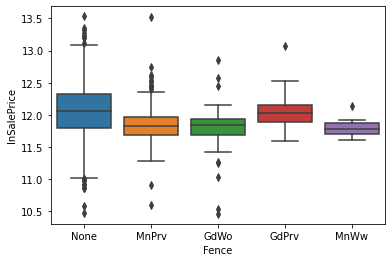

In [129]:
print(pd.value_counts(df_all.Fence, normalize='columns'))
sns.boxplot( x = df_train['Fence'], y=df_train["lnSalePrice"])

In [130]:

df_all=df_all.drop(columns=['Fence'])
printsize(df_all)

Size of dataset: 2916 rows, 68 columns


### 4.1.X MiscFeature

Delete

None    0.963992
Shed    0.032579
Gar2    0.001715
Othr    0.001372
TenC    0.000343
Name: MiscFeature, dtype: float64


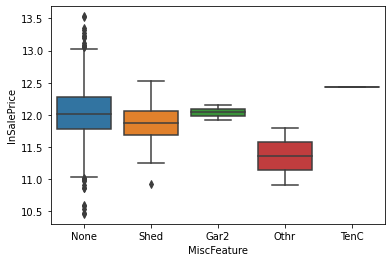

In [131]:
print(pd.value_counts(df_all.MiscFeature, normalize='columns'))
sns.boxplot( x = df_train['MiscFeature'], y=df_train["lnSalePrice"])

In [132]:
df_all=df_all.drop(columns=['MiscFeature'])
printsize(df_all)

Size of dataset: 2916 rows, 67 columns


### 4.1.X SaleType

New is 1; all else is referant

WD       0.865912
New      0.081276
COD      0.029835
ConLD    0.008916
CWD      0.004115
ConLI    0.003086
ConLw    0.002743
Oth      0.002401
Con      0.001715
Name: SaleType, dtype: float64


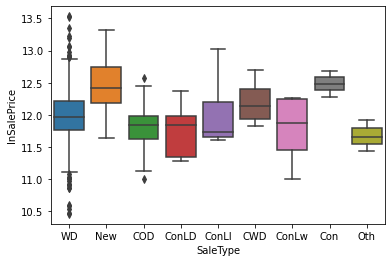

In [133]:
print(pd.value_counts(df_all.SaleType, normalize='columns'))
sns.boxplot( x = df_train['SaleType'], y=df_train["lnSalePrice"])

In [134]:
print(pd.value_counts(df_all.SaleType, normalize='columns'))

saletype_dict = {'WD': 0, 'CWD': 0, 'VWD': 0, 'New': 1, 'COD': 0, 'Con': 0, 'ConLw': 0, 'ConLI': 0, 'ConLD': 0, 'Oth': 0} #New

df_all['SaleType_New'] = df_all['SaleType'].replace(dict(saletype_dict))

print(pd.value_counts(df_all.SaleType_New, normalize='columns'))
df_all=df_all.drop(columns=['SaleType'])
printsize(df_all)

WD       0.865912
New      0.081276
COD      0.029835
ConLD    0.008916
CWD      0.004115
ConLI    0.003086
ConLw    0.002743
Oth      0.002401
Con      0.001715
Name: SaleType, dtype: float64
0    0.918724
1    0.081276
Name: SaleType_New, dtype: float64
Size of dataset: 2916 rows, 67 columns


### 4.1.X SaleCondition

Dropped.  "Partial" is picked up in the "New" above

Normal     0.823388
Partial    0.083333
Abnorml    0.065158
Family     0.015775
Alloca     0.008230
AdjLand    0.004115
Name: SaleCondition, dtype: float64


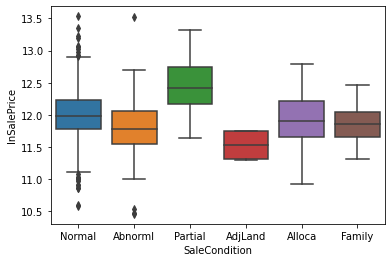

In [135]:
print(pd.value_counts(df_all.SaleCondition, normalize='columns'))
sns.boxplot( x = df_train['SaleCondition'], y=df_train["lnSalePrice"])

In [136]:

df_all=df_all.drop(columns=['SaleCondition'])
printsize(df_all)

Size of dataset: 2916 rows, 66 columns


### 4.1.X Verify Completeness

We should have only numeric columns at this point.

In [137]:
print(df_all.select_dtypes(exclude=np.number).shape)

(2916, 0)


## 4.2 Combine Existing Features

We will also be creating indicators, interaction effects and splines, as well as other pragmatic transformations (e.g., "Year Built" --> "Age of House")

### 4.2.1 Methods



In [138]:
def compare(xvar):
  colors = ['red', 'red', 'red', 'purple', 'purple', 'yellow', 'yellow', 'green', 'green', 'green']
  sns.scatterplot(x=df_train[xvar], y = df_train['lnSalePrice'], hue = df_train['OverallQual'], palette = colors)


### 4.2.2 Permutations with the Reduced/One-Hot Categoricals


In [139]:
# LotShape_Irr is the referant versus a regular lot shape
df_all['LotShape_Irr_x_LotArea'] = df_all['LotShape_Irr'] * df_all['LotArea']

# Condition_Neg and Condition_Pos are indicators of property location features
df_all['Condition_Neg_x_LotArea'] = df_all['Condition_Neg'] * df_all['LotArea']
df_all['Condition_Pos_x_LotArea'] = df_all['Condition_Pos'] * df_all['LotArea']

# BldgType_Other references a house that’s not a single-family.  May interact with square footage
df_all['BldgType_Other_x_GrLivArea'] = df_all['BldgType_Other'] * df_all['GrLivArea']
df_all['BldgType_Other_x_TotalBsmtSF'] = df_all['BldgType_Other'] * df_all['TotalBsmtSF']

# HouseStyle_2Story, _15Fin, _Other are houses that aren’t 1 story.  Interact with inside square footage

df_all['HouseStyle_2Story_x_GrLivArea'] =   df_all['HouseStyle_2Story'] * df_all['GrLivArea']
df_all['HouseStyle_2Story_x_TotalBsmtSF'] = df_all['HouseStyle_2Story'] * df_all['TotalBsmtSF']

df_all['HouseStyle_15Fin_x_GrLivArea'] =   df_all['HouseStyle_15Fin'] * df_all['GrLivArea']
df_all['HouseStyle_15Fin_x_TotalBsmtSF'] = df_all['HouseStyle_15Fin'] * df_all['TotalBsmtSF']

df_all['HouseStyle_Other_x_GrLivArea'] =   df_all['HouseStyle_Other'] * df_all['GrLivArea']
df_all['HouseStyle_Other_x_TotalBsmtSF'] = df_all['HouseStyle_Other'] * df_all['TotalBsmtSF']

# OverallQual_Med, _High, _VHigh are important for all of these things

df_all['OverallQual_Med_x_GrLivArea'] =   df_all['OverallQual_Med'] * df_all['GrLivArea']
df_all['OverallQual_Med_x_TotalBsmtSF'] = df_all['OverallQual_Med'] * df_all['TotalBsmtSF']

df_all['OverallQual_High_x_GrLivArea'] =   df_all['OverallQual_High'] * df_all['GrLivArea']
df_all['OverallQual_High_x_TotalBsmtSF'] = df_all['OverallQual_High'] * df_all['TotalBsmtSF']

df_all['OverallQual_VHigh_x_GrLivArea'] =   df_all['OverallQual_VHigh'] * df_all['GrLivArea']
df_all['OverallQual_VHigh_x_TotalBsmtSF'] = df_all['OverallQual_VHigh'] * df_all['TotalBsmtSF']

# Also multiply against OverallCond

#BsmtQual_Good and _Great is a multiplier against the basement square footage
#Same with BsmtFinType_Good

df_all['BsmtQual_Good_x_TotalBsmtSF'] = df_all['BsmtQual_Good'] * df_all['TotalBsmtSF']
df_all['BsmtQual_Great_x_TotalBsmtSF'] = df_all['BsmtQual_Great'] * df_all['TotalBsmtSF']
df_all['BsmtFinType_Good_x_TotalBsmtSF'] = df_all['BsmtFinType_Good'] * df_all['TotalBsmtSF']


#GarageType_Attached interacts with Garage Square Footage or whatever

df_all['GarageType_Attached_x_GarageArea'] = df_all['GarageType_Attached'] * df_all['GarageArea']

#SaleType_New is important

### 4.2.3 Other Permutations, excl. log and power transforms

In [140]:
df_all['HouseAge'] = df_all['YrSold'] - df_all['YearBuilt']
df_all['HouseAge_Remodel'] = df_all['YrSold'] - df_all['YearRemodAdd']

In [141]:
# I was just about to one-hot encode bathrooms
# Also was going to come up with a permutation relating the number of bedrooms to the number of full bathrooms

## 4.4 Drops

In [142]:
# Dropping YearBuilt and YearRemodAdd since those are captured by the new vars "HouseAge" and "HouseAge_Remodel"
df_all.drop(['YearBuilt', 'YearRemodAdd'], axis=1, inplace=True)

# Dropping PoolArea since this is captured through the booleans of PoolGreat and PoolOK
df_all.drop(['PoolArea'], axis=1, inplace=True)



## 4.X Split Train and Test

In [143]:
df_train_final = df_all[:ntrain]
df_test_final = df_all[ntrain:]

printsize(df_train_final)
printsize(df_test_final)

Size of dataset: 1457 rows, 86 columns
Size of dataset: 1459 rows, 86 columns


## 4.X Normalize Skewed Variables

# 5 Build Models

Approach largely pulled from https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression



## 5.1 Setup - Libraries and Methods

In [144]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
#from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
#from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#from sklearn.compose import ColumnTransformer

#import xgboost as xgb
#import lightgbm as lgb

In [145]:
#Validation function
n_folds = 5

def kfold_cv_rmsle(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmsle = np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmsle)

def kfold_cv_pred(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    y_pred = cross_val_predict(model, X.values, y, cv=kf)
    return(y_pred)

## 5.2 Linear Regression, no Scaler

There's no scaling of variables here.  Provided as a benchmark set

In [152]:
lr = LinearRegression()
lr_score = kfold_cv_rmsle(lr, df_train_final, y_train_final)
print("Unscaled Linear Regression score: {:.6f} ({:.6f})\n".format(lr_score.mean(), lr_score.std()))



Unscaled Linear Regression score: 0.127359 (0.008396)



## 5.3 Linear Regression with StandardScaler

Note: StandardScaler converts all data fields where mean = 0 and stdev = 1

In [153]:
scaler = MinMaxScaler(feature_range=[1,2])
scaler = RobustScaler()
power = PowerTransformer(method='box-cox')

lr_ss = make_pipeline(scaler, LinearRegression())
lr_ss_score = kfold_cv_rmsle(lr_ss, df_train_final, y_train_final)
print("Linear Regression Standard Scaler score: {:.6f} ({:.6f})\n".format(lr_ss_score.mean(), lr_ss_score.std()))

Linear Regression Standard Scaler score: 0.127359 (0.008396)



In [148]:
lr_mm = make_pipeline(MinMaxScaler(), LinearRegression())
lr_mm_score = kfold_cv_rmsle(lr_mm, df_train_final, y_train_final)
print("Linear Regression MinMax Scaler score: {:.6f} ({:.6f})\n".format(lr_mm_score.mean(), lr_mm_score.std()))

Linear Regression MinMax Scaler score: 0.1274 (0.0084)



In [205]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = kfold_cv_rmsle(KRR, df_train_final, y_train_final)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 5.0916 (1.8014)



## 5.3 LinReg with no SciKit Learn

In [156]:
X_t, X_v, y_t, y_v = train_test_split(df_train_final, y_train_final, test_size=.2, random_state=422)

In [159]:
from statsmodels.api import OLS
from statsmodels.tools.eval_measures import rmse


In [158]:

lr = OLS(y_t,X_t).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.332e+05
Date:                Fri, 14 Jan 2022   Prob (F-statistic):                        0.00
Time:                        16:26:38   Log-Likelihood:                          826.80
No. Observations:                1165   AIC:                                     -1488.
Df Residuals:                    1082   BIC:                                     -1068.
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
LotFrontage                          0.0005      0.000      1.949      0.052   -3.54e-06       0.001
LotArea                           7.359e-06   1.62e-06      4.538      0.000    4.18e-06    1.05e-05
MasVnrArea                        2.524e-05   3.15e-05      0.801      0.424   -3.66e-05    8.71e-05
BsmtFinSF1                        1.334e-05    2.2e-05      0.606      0.545   -2.99e-05    5.65e-05
BsmtFinSF2                       -1.576e-05    2.7e-05     -0.584      0.560   -6.87e-05    3.72e-05
BsmtUnfSF                        -4.947e-05   2.09e-05     -2.369      0.018   -9.04e-05    -8.5e-06
TotalBsmtSF                      -5.189e-05   5.85e-05     -0.888      0.375      -0.000    6.28e-05
1stFlrSF                             0.0002   3.74e-05      4.794      0.000       0.000       0.000
2ndFlrSF                             0.0002   4.06e-05      5.900      0.000       0.000       0.000
LowQualFinSF                         0.0001   6.91e-05      1.721      0.086   -1.67e-05       0.000
GrLivArea                            0.0005   6.96e-05      7.729      0.000       0.000       0.001
BsmtFullBath                         0.0323      0.011      2.838      0.005       0.010       0.055
BsmtHalfBath                         0.0188      0.017      1.112      0.267      -0.014       0.052
FullBath                             0.0105      0.012      0.855      0.393      -0.014       0.035
HalfBath                             0.0216      0.012      1.873      0.061      -0.001       0.044
BedroomAbvGr                        -0.0063      0.007     -0.839      0.402      -0.021       0.008
KitchenAbvGr                        -0.0393      0.025     -1.600      0.110      -0.087       0.009
TotRmsAbvGrd                         0.0065      0.005      1.242      0.215      -0.004       0.017
Fireplaces                           0.0358      0.007      4.791      0.000       0.021       0.051
GarageYrBlt                          0.0001      0.000      0.434      0.664      -0.001       0.001
GarageCars                           0.0409      0.013      3.218      0.001       0.016       0.066
GarageArea                        6.377e-05    5.1e-05      1.251      0.211   -3.63e-05       0.000
WoodDeckSF                        8.207e-05   3.29e-05      2.494      0.013    1.75e-05       0.000
OpenPorchSF                      -1.908e-05   6.17e-05     -0.309      0.757      -0.000       0.000
EnclosedPorch                     7.021e-05   7.09e-05      0.991      0.322   -6.88e-05       0.000
3SsnPorch                            0.0001      0.000      1.136      0.256      -0.000       0.000
ScreenPorch                          0.0003   6.92e-05 

In [162]:
y_t_pred = lr.predict(X_t)
y_v_pred = lr.predict(X_v)
print(rmse(y_t, y_t_pred))
print(rmse(y_v, y_v_pred))

0.11899884697945642
0.11542735844267125


### 5.3.X Apply linreg model to test set

In [204]:
sub = pd.DataFrame()
sub['Id'] = test_ID
y_test_pred = lr.predict(df_test_final)
y_test_pred = y_test_pred.to_frame()
y_test_pred = y_test_pred.rename(columns = {0:'SalePrice'})
y_test_pred.reset_index(drop=True, inplace=True)
print(type(y_test_pred))
print(y_test_pred.head())
sub['SalePrice'] = y_test_pred['SalePrice']
sub['SalePrice'] = np.exp(sub['SalePrice'])

print(sub.head())

sub.to_csv('submission.csv',index=False)


<class 'pandas.core.frame.DataFrame'>
   SalePrice
0  11.659354
1  12.004643
2  12.085764
3  12.254472
4  12.166242
     Id      SalePrice
0  1461  115769.242531
1  1462  163512.155725
2  1463  177329.356733
3  1464  209917.894014
4  1465  192190.377491
